In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'ai4i2020.csv' 
data = pd.read_csv(file_path)

# Initialize the session ID
session_id = 0
session_ids = []

# Assign session IDs based on the reset of the Tool wear column
for i in range(len(data)):
    if i == 0:
        session_ids.append(session_id)
    else:
        if data['Tool wear [min]'].iloc[i] == 0 and data['Tool wear [min]'].iloc[i - 1] != 0:
            session_id += 1
        session_ids.append(session_id)

# Add the Session ID column
data['Session_ID'] = session_ids

# Define failure related columns
failure_columns = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Add Machine failure column if not already present
if 'Machine failure' not in data.columns:
    data['Machine failure'] = data[failure_columns].max(axis=1)

# Perform interpolation for each session
interpolated_data = []

for session, group in data.groupby('Session_ID'):
    # Get the full range of Tool wear [min]
    full_range = pd.DataFrame({'Tool wear [min]': np.arange(0, group['Tool wear [min]'].max() + 1)})
    
    # Merge with the group data to ensure all tool wear values are included
    group = pd.merge(full_range, group, on='Tool wear [min]', how='left')
    
    # Forward-fill and back-fill for categorical columns (Type, Product ID, Session_ID)
    for col in ['Type', 'Product ID', 'Session_ID']:
        group[col] = group[col].fillna(method='ffill').fillna(method='bfill')
    
    # Perform linear interpolation for numerical columns except failure columns
    for col in group.columns:
        if col not in ['Tool wear [min]', 'Session_ID'] + failure_columns + ['Type', 'Product ID', 'Machine failure']:
            group[col] = group[col].interpolate(method='linear', limit_direction='both')
    
    # Fill failure-related columns: keep 1 if present, otherwise fill with 0
    for col in failure_columns + ['Machine failure']:
        group[col] = group[col].fillna(0)
    
    # Append the processed session
    interpolated_data.append(group)

# Combine all interpolated sessions back into a single DataFrame
data_interpolated = pd.concat(interpolated_data, ignore_index=True)

# `data_interpolated` is now preprocessed and ready for train-test splitting.
print(f"Data shape after preprocessing: {data_interpolated.shape}")

#save to csv
data_interpolated.to_csv('ai4i2020_interpolated.csv', index=False)


C:\Users\issaa\AppData\Local\Temp\ipykernel_28732\690784300.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group[col] = group[col].fillna(method='ffill').fillna(method='bfill')
C:\Users\issaa\AppData\Local\Temp\ipykernel_28732\690784300.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group[col] = group[col].fillna(method='ffill').fillna(method='bfill')
C:\Users\issaa\AppData\Local\Temp\ipykernel_28732\690784300.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group[col] = group[col].fillna(method='ffill').fillna(method='bfill')
C:\Users\issaa\AppData\Local\Temp\ipykernel_28732\690784300.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.b

Data shape after preprocessing: (25813, 15)


In [10]:
from sklearn.model_selection import train_test_split

# Define columns for indicators
indicator_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]']

# Define sliding window size
window_size = 10  # Number of timesteps in each sliding window

# Split sessions into training and testing sets
unique_sessions = data_interpolated['Session_ID'].unique()
train_sessions, test_sessions = train_test_split(unique_sessions, test_size=0.3, random_state=42)

# Separate training and testing data
train_data = data_interpolated[data_interpolated['Session_ID'].isin(train_sessions)]
test_data = data_interpolated[data_interpolated['Session_ID'].isin(test_sessions)]

# Create sliding windows for training data
X_train, y_train = [], []
for session_id in train_sessions:
    session_data = train_data[train_data['Session_ID'] == session_id].reset_index(drop=True)
    if len(session_data) < window_size + 1:
        continue  # Skip sessions that are too short
    
    for i in range(len(session_data) - window_size):
        X_train.append(session_data[indicator_columns].iloc[i:i + window_size].values)
        y_train.append(session_data[indicator_columns].iloc[i + window_size].values)

# Create sliding windows for testing data
X_test, y_test = [], []
for session_id in test_sessions:
    session_data = test_data[test_data['Session_ID'] == session_id].reset_index(drop=True)
    if len(session_data) < window_size + 1:
        continue  # Skip sessions that are too short
    
    for i in range(len(session_data) - window_size):
        X_test.append(session_data[indicator_columns].iloc[i:i + window_size].values)
        y_test.append(session_data[indicator_columns].iloc[i + window_size].values)

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure data dimensions match Conv1D requirements
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (17182, 10, 4), y_train shape: (17182, 4)
X_test shape: (7431, 10, 4), y_test shape: (7431, 4)


Epoch 1/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 44021.0703 - mae: 111.7471 - val_loss: 3500.7649 - val_mae: 27.9349
Epoch 2/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4870.2734 - mae: 39.5511 - val_loss: 2797.6091 - val_mae: 26.7455
Epoch 3/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3550.1880 - mae: 32.8757 - val_loss: 2965.6909 - val_mae: 31.6959
Epoch 4/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3089.6917 - mae: 28.5949 - val_loss: 13067.6943 - val_mae: 76.4743
Epoch 5/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2633.5442 - mae: 26.0066 - val_loss: 7842.0308 - val_mae: 61.1198
Epoch 6/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2576.3296 - mae: 24.8239 - val_loss: 16423.2246 - val_mae: 89.1267
Epoch 7/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2287.5378 - mae: 22.9537 - val_loss: 29586.2070 - val_mae: 118.1732
Epoch 8/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2224.0066 - mae: 22.5425 - val_loss: 19790.6777 - va

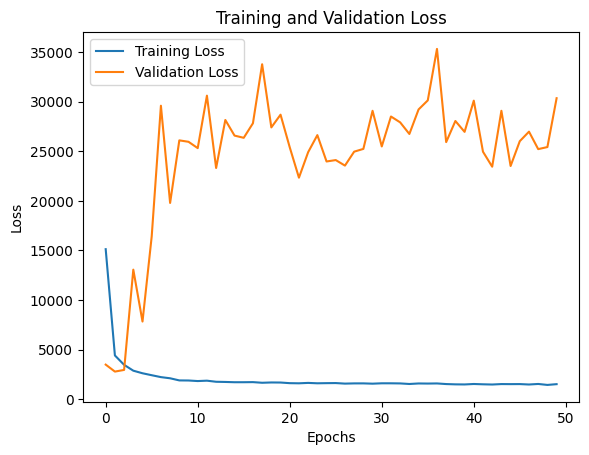

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt

# CNN Model Definition
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1])  # Output layer for the 4 features
])

# Compile the Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the Model
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluate the Model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


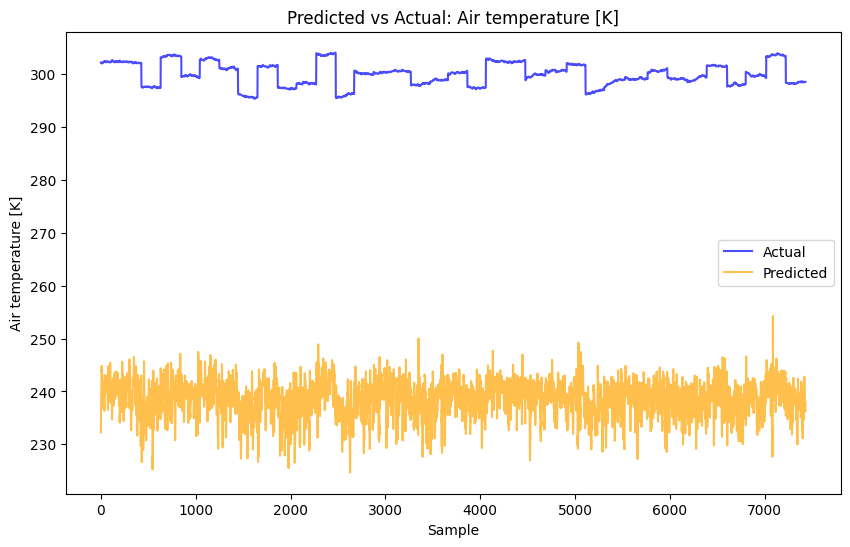

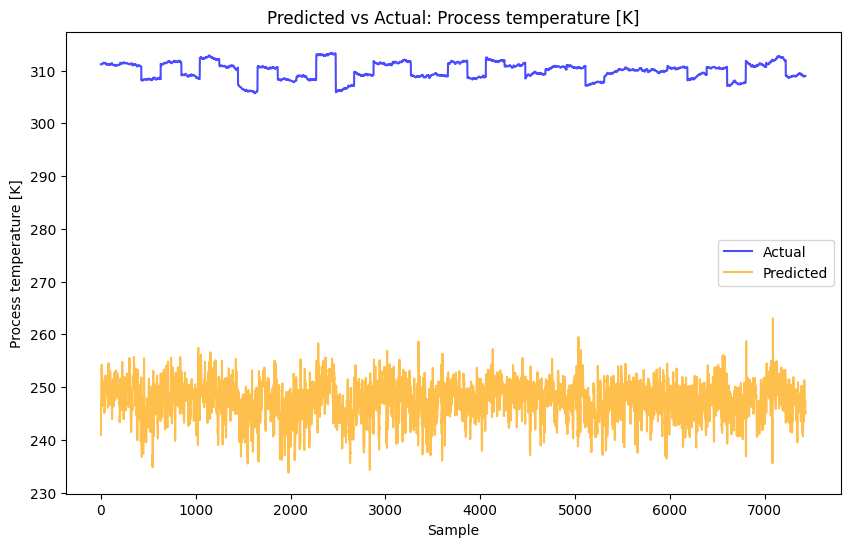

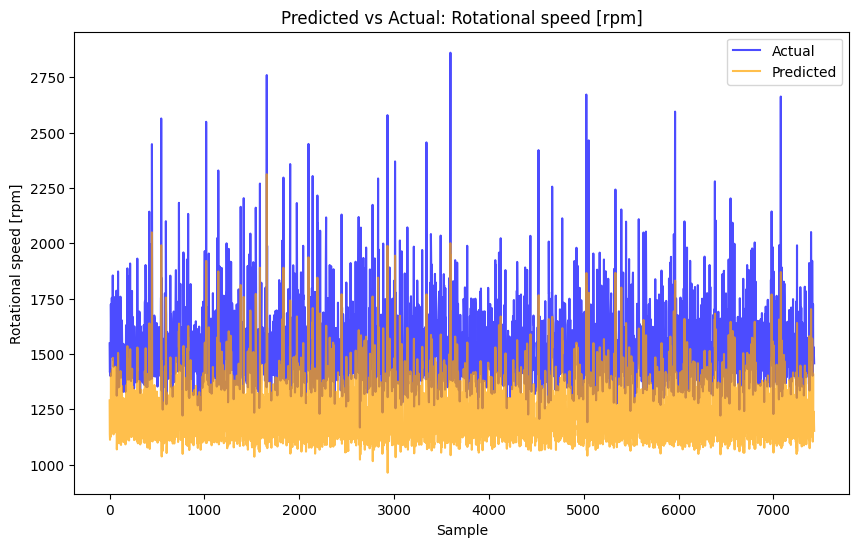

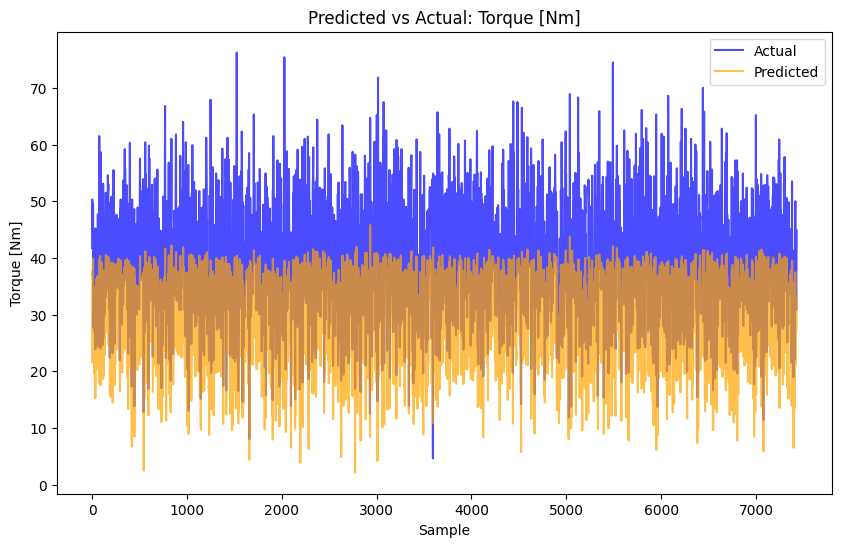

In [4]:
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test)

# Plot predicted vs actual for each indicator
indicator_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]']

for i, column in enumerate(indicator_columns):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:, i], label='Actual', color='blue', alpha=0.7)
    plt.plot(y_pred[:, i], label='Predicted', color='orange', alpha=0.7)
    plt.title(f"Predicted vs Actual: {column}")
    plt.xlabel("Sample")
    plt.ylabel(column)
    plt.legend()
    plt.show()


In [6]:
import pandas as pd

# Create a DataFrame for aligned predictions
aligned_predictions = []

for session_id in test_sessions:
    session_data = test_data[test_data['Session_ID'] == session_id].reset_index(drop=True)
    if len(session_data) < window_size + 1:
        continue  # Skip short sessions

    for i in range(len(session_data) - window_size):
        aligned_predictions.append({
            'Session_ID': session_id,
            'Time_Step': i + window_size,  # Time step in the session
            'Actual': y_test[i],
            'Predicted': y_pred[i]
        })

# Convert aligned predictions to a DataFrame
predictions_df = pd.DataFrame(aligned_predictions)

print(predictions_df.head())


   Session_ID  Time_Step                          Actual  \
0        44.0         10  [302.15, 311.2, 1548.0, 41.75]   
1        44.0         11    [302.1, 311.2, 1447.0, 50.3]   
2        44.0         12   [302.1, 311.2, 1432.0, 49.15]   
3        44.0         13    [302.1, 311.2, 1417.0, 48.0]   
4        44.0         14  [302.05, 311.2, 1425.5, 46.45]   

                                      Predicted  
0   [232.25177, 240.94745, 1290.4834, 21.62621]  
1   [236.22134, 245.80331, 1141.572, 33.257515]  
2   [237.61598, 246.95853, 1138.1326, 35.13798]  
3  [238.04584, 247.20949, 1120.8972, 35.763638]  
4  [240.06262, 249.16936, 1112.5367, 37.703968]  


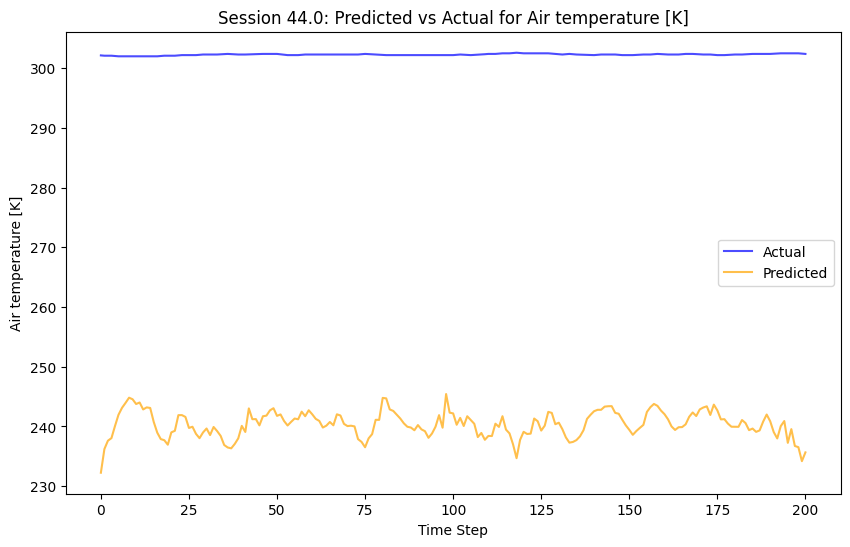

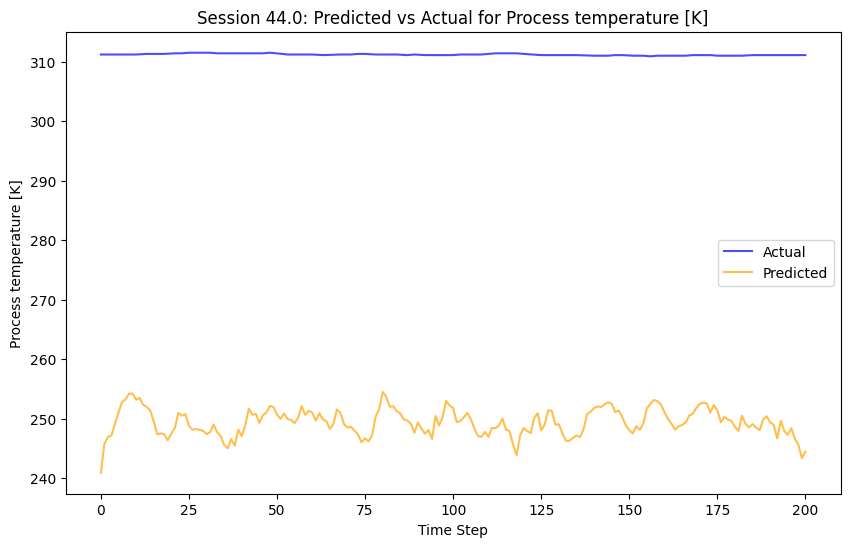

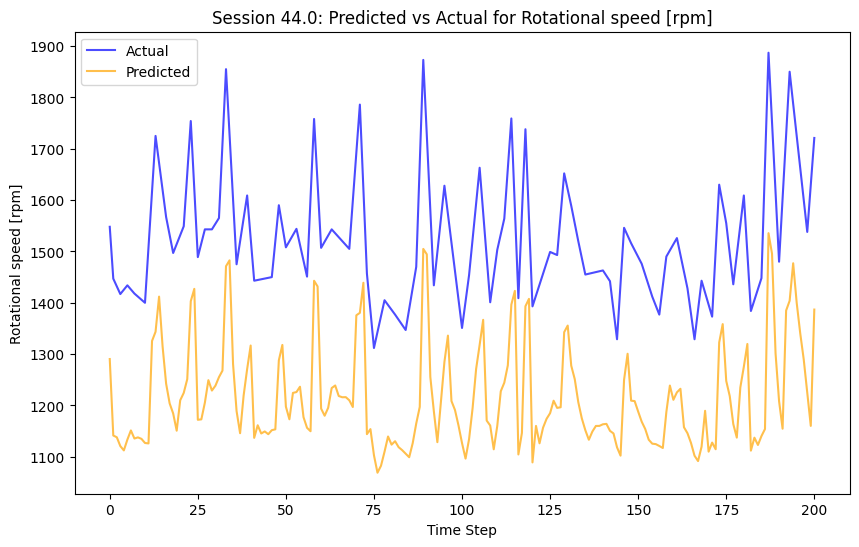

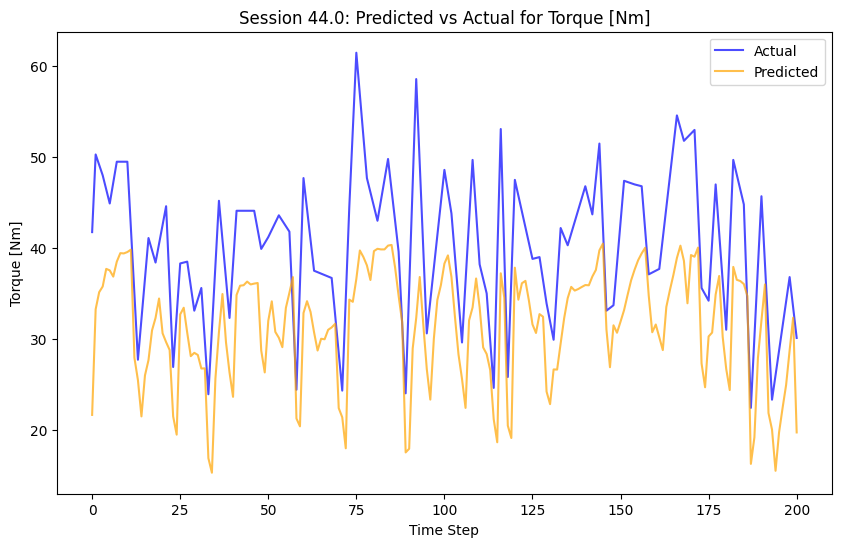

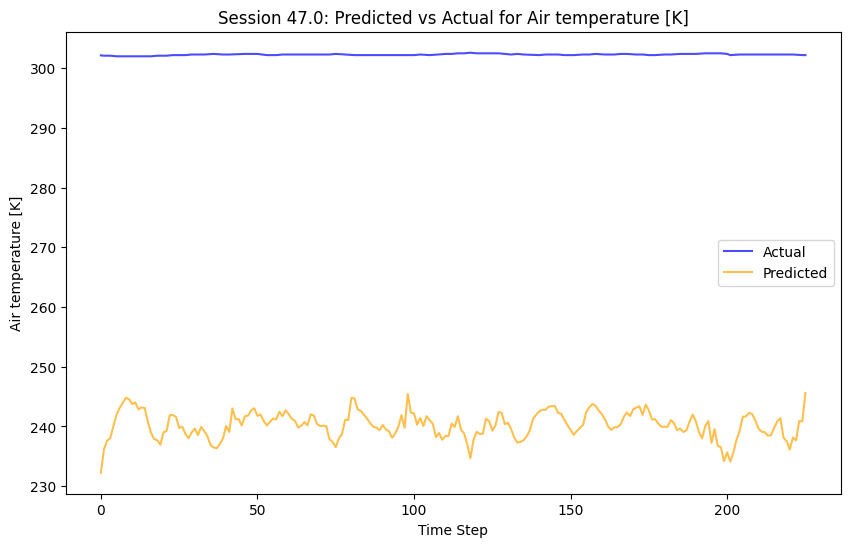

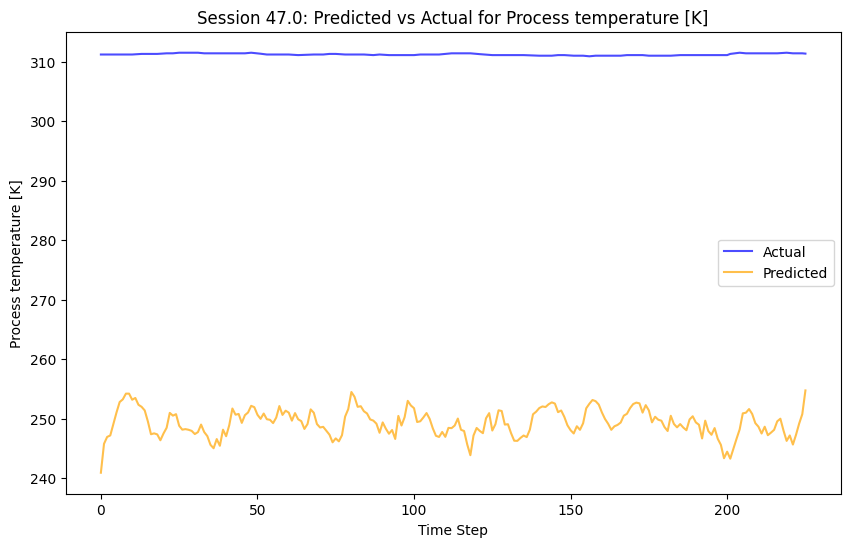

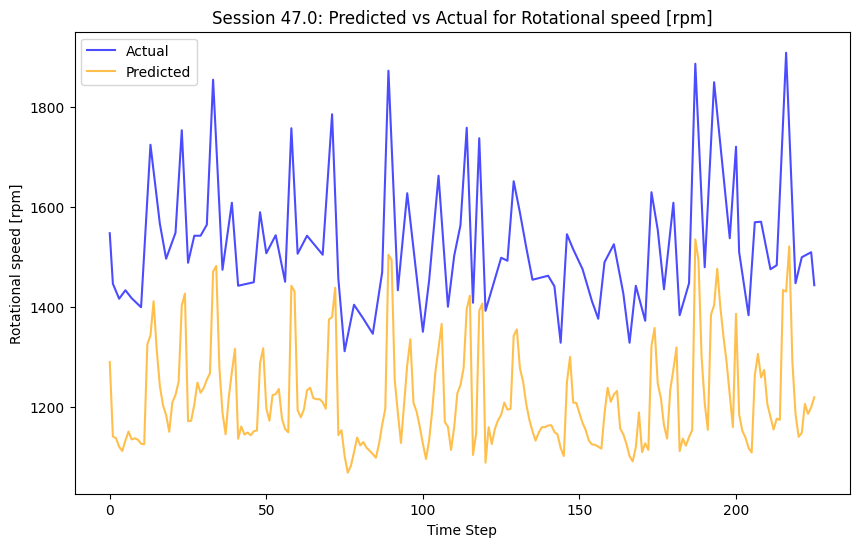

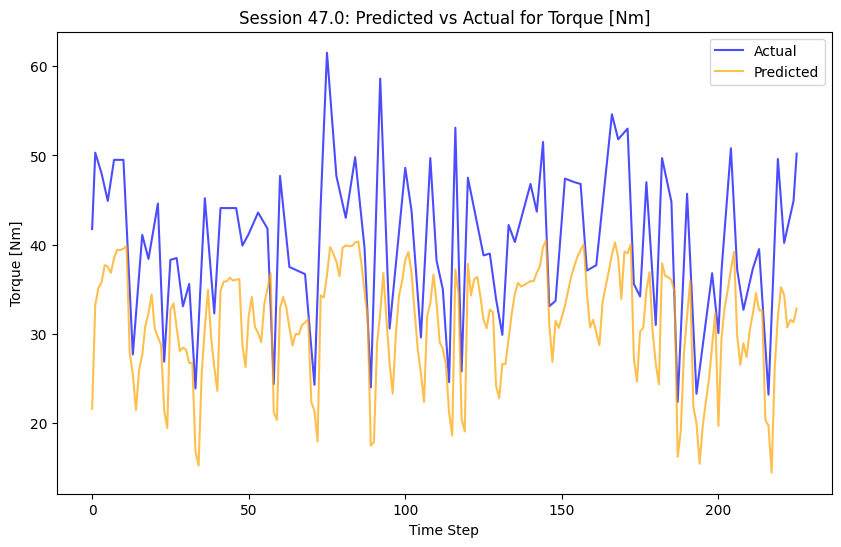

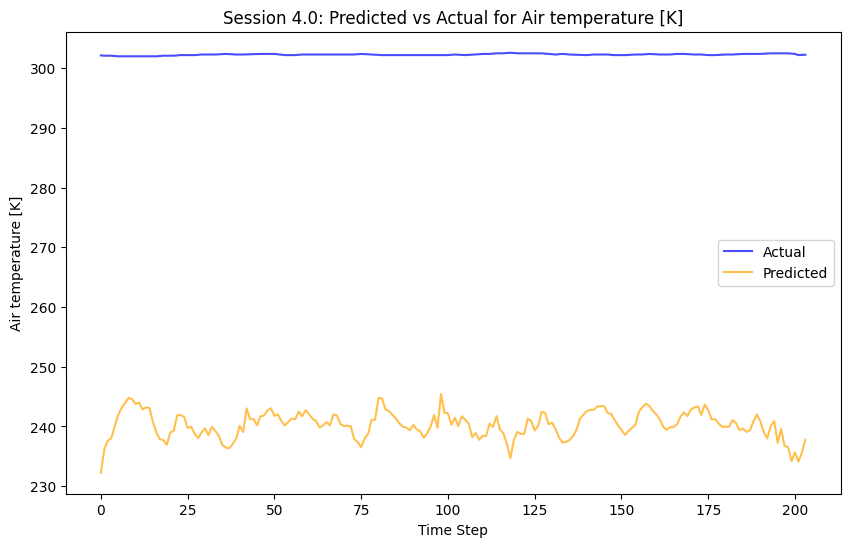

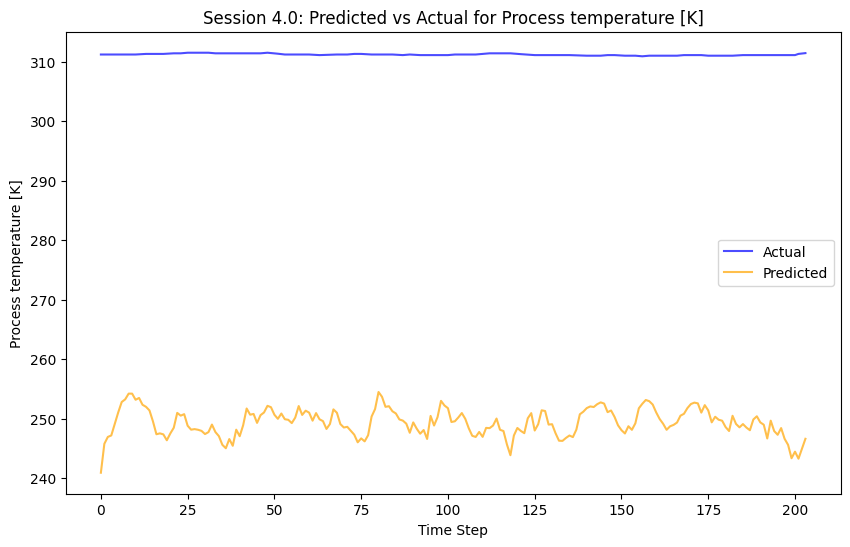

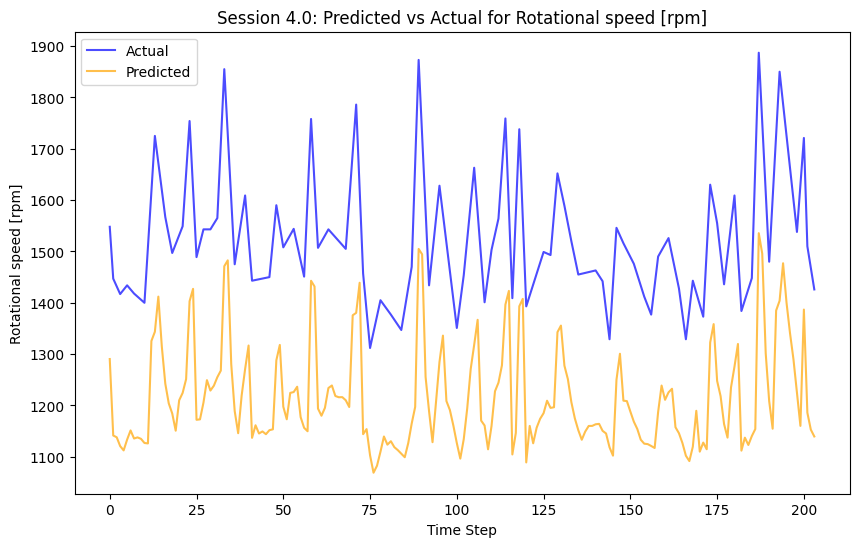

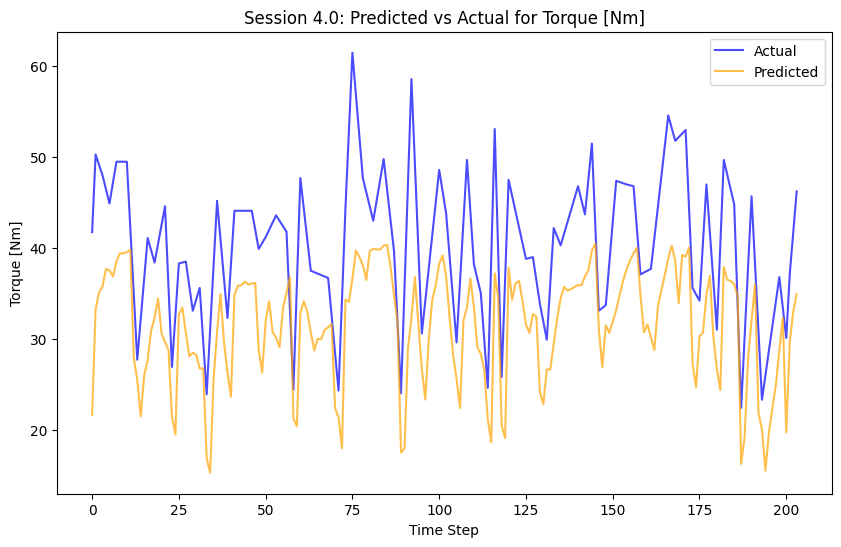

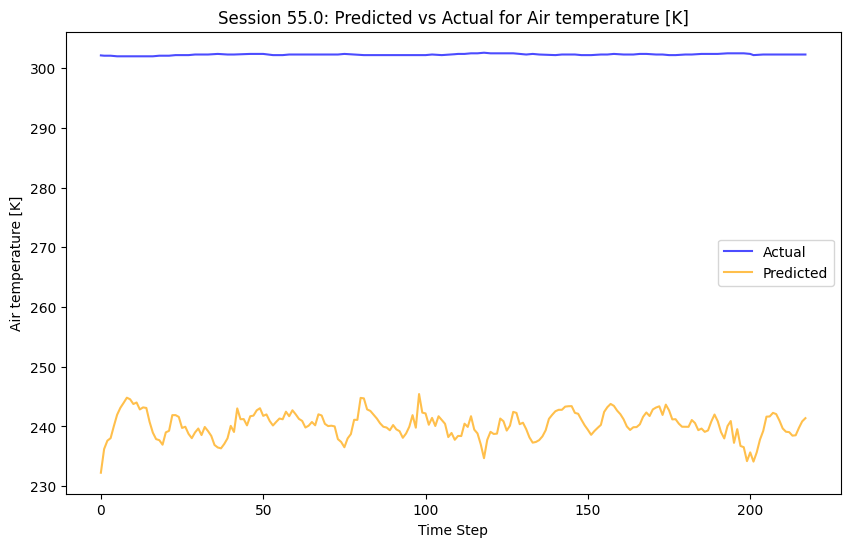

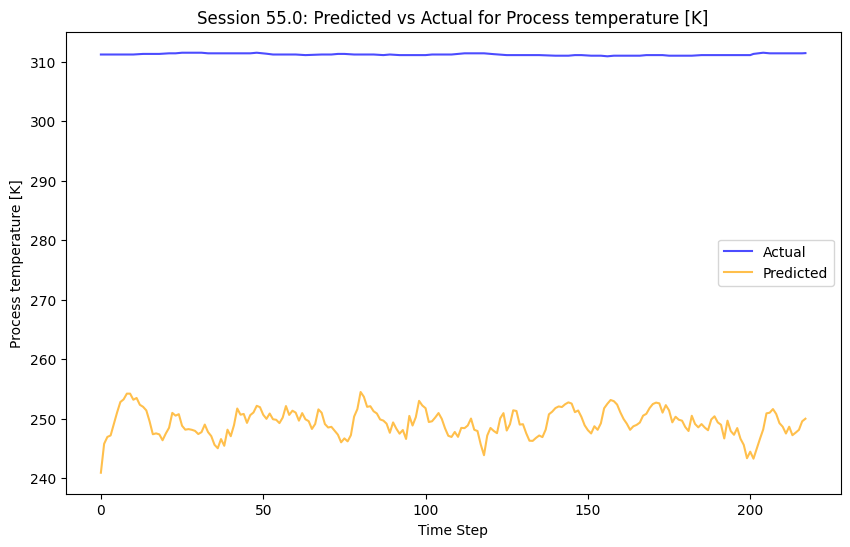

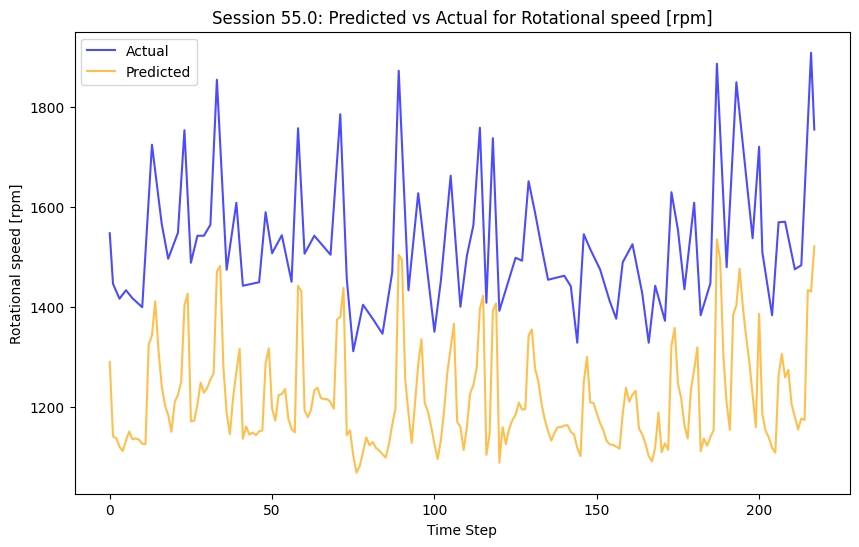

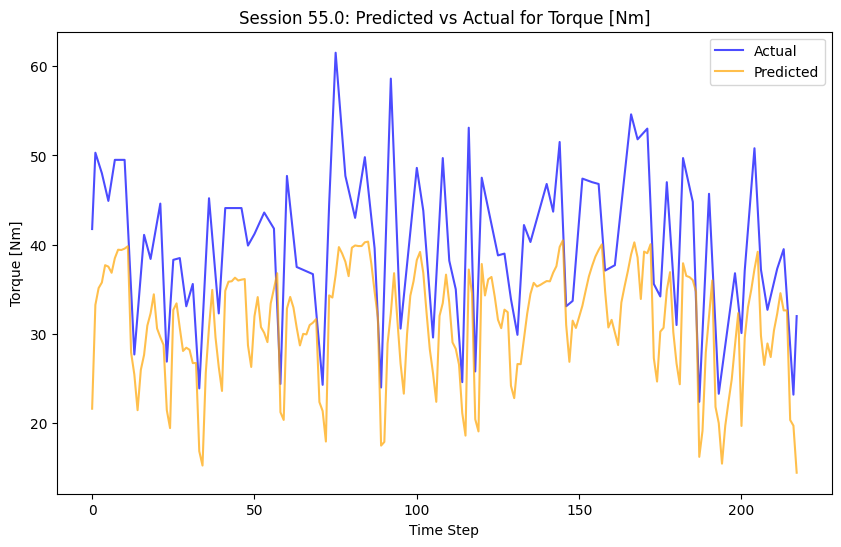

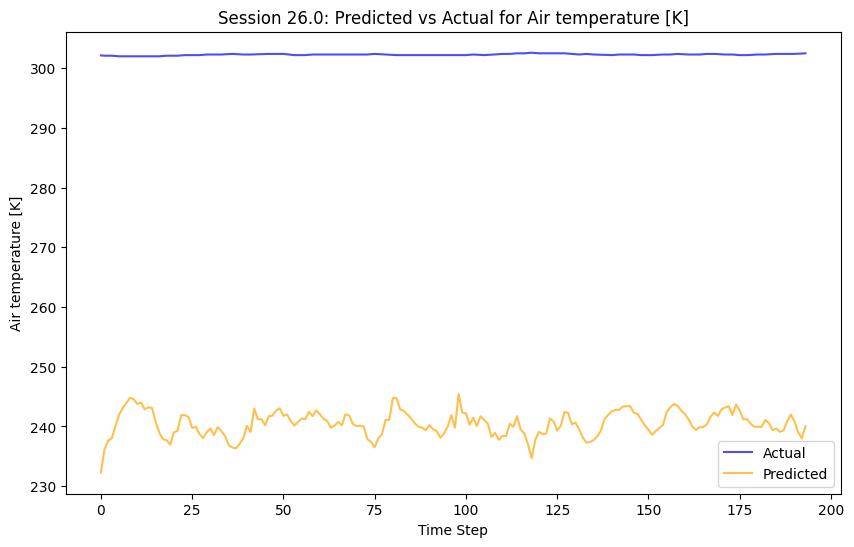

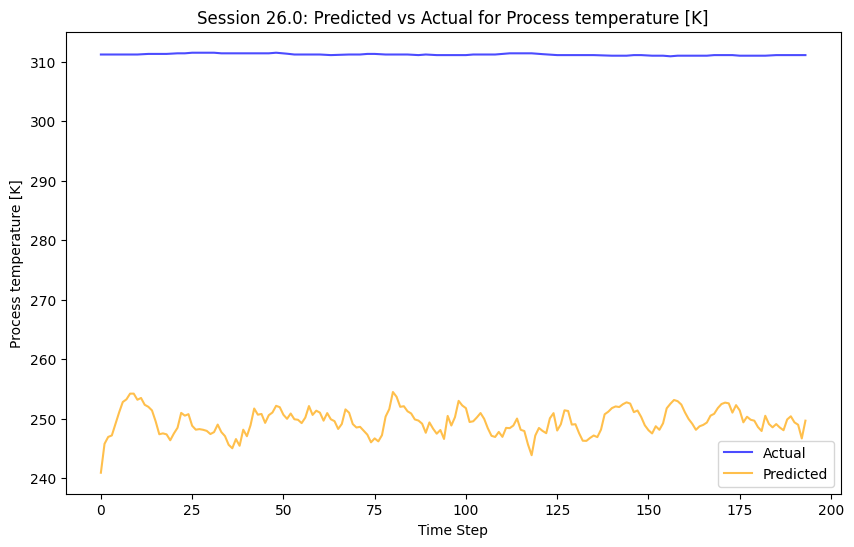

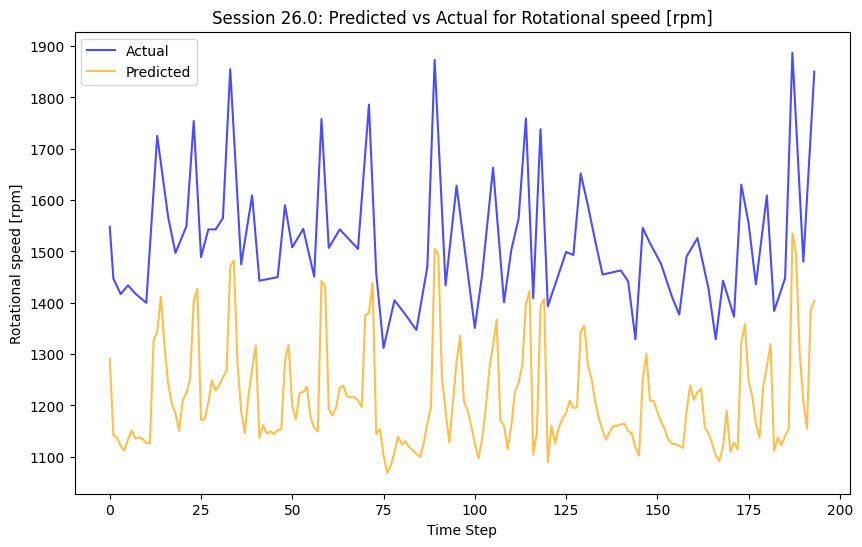

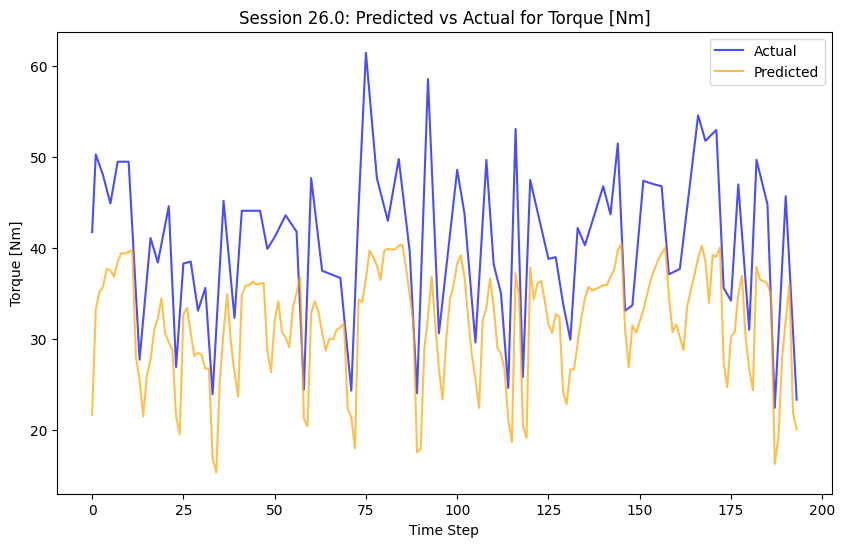

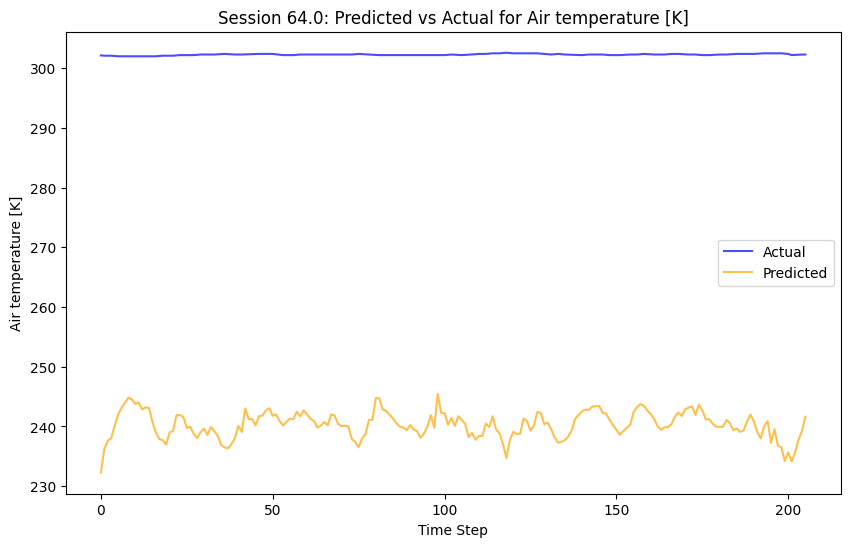

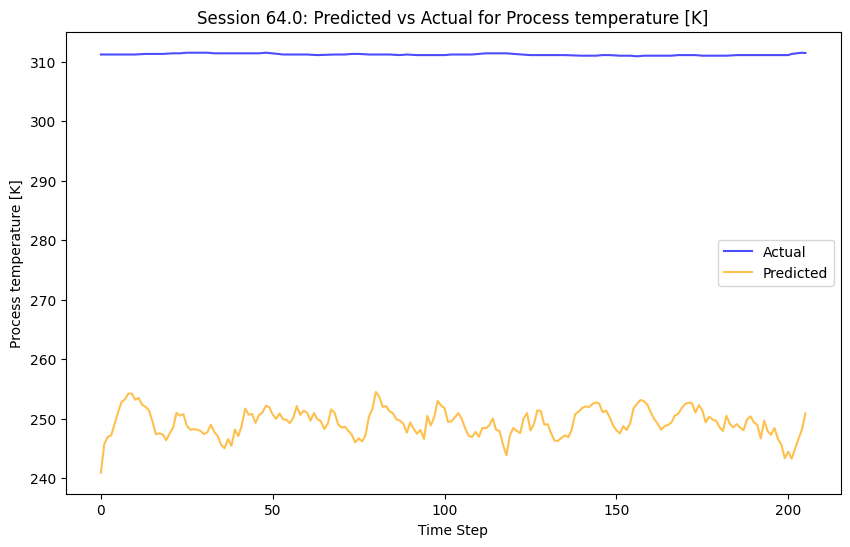

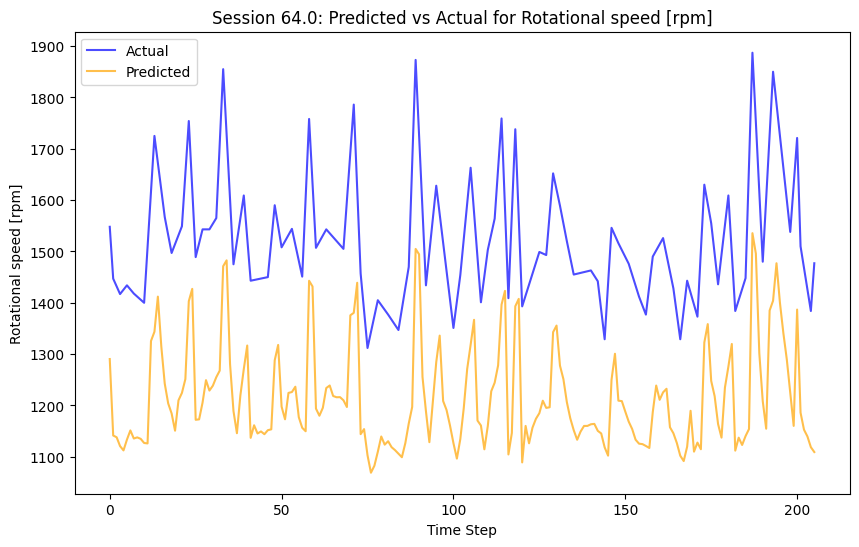

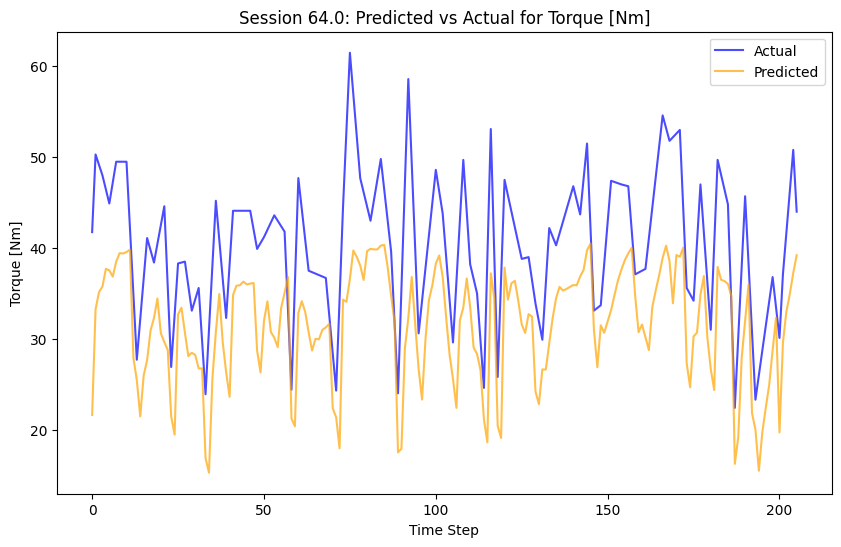

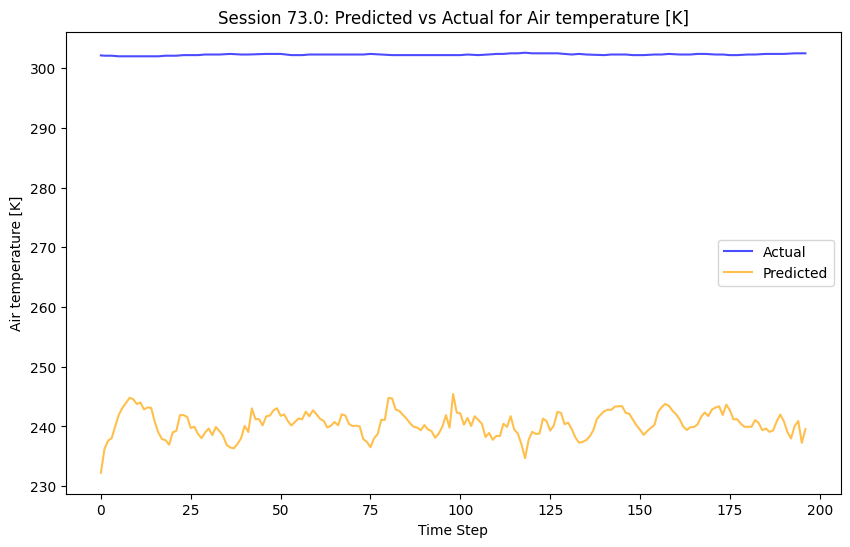

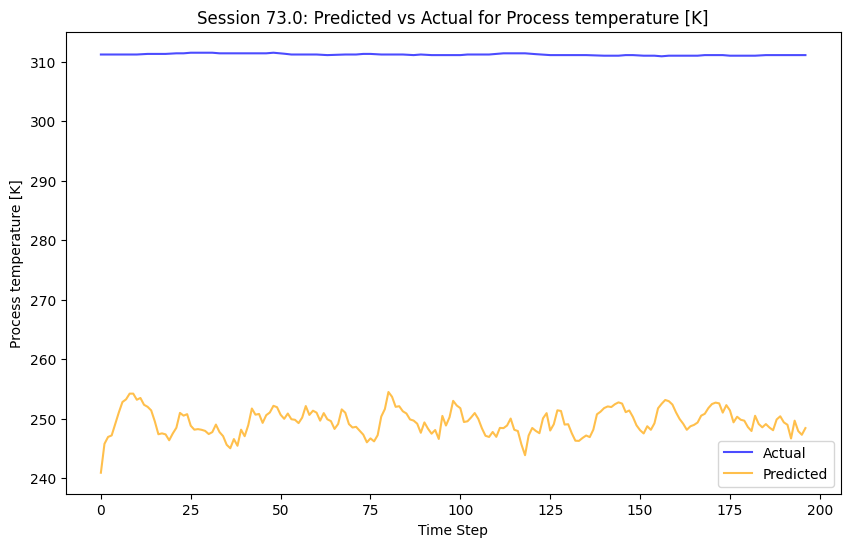

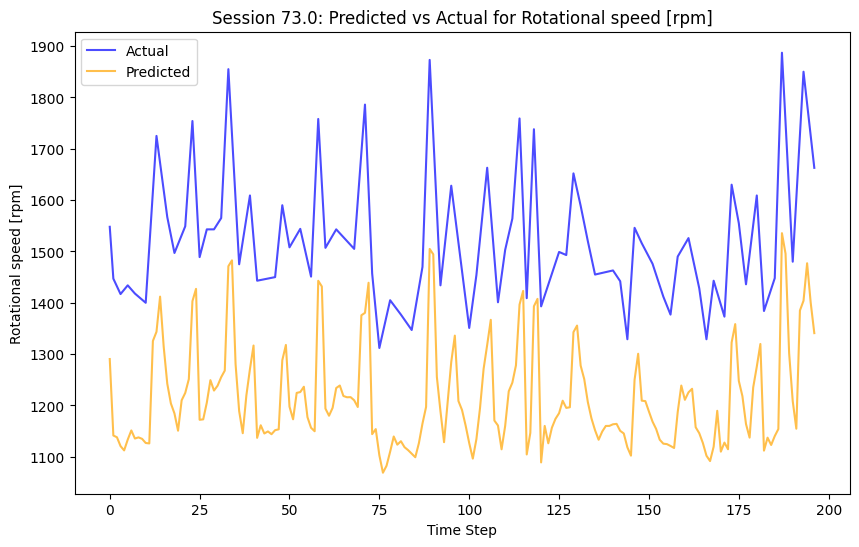

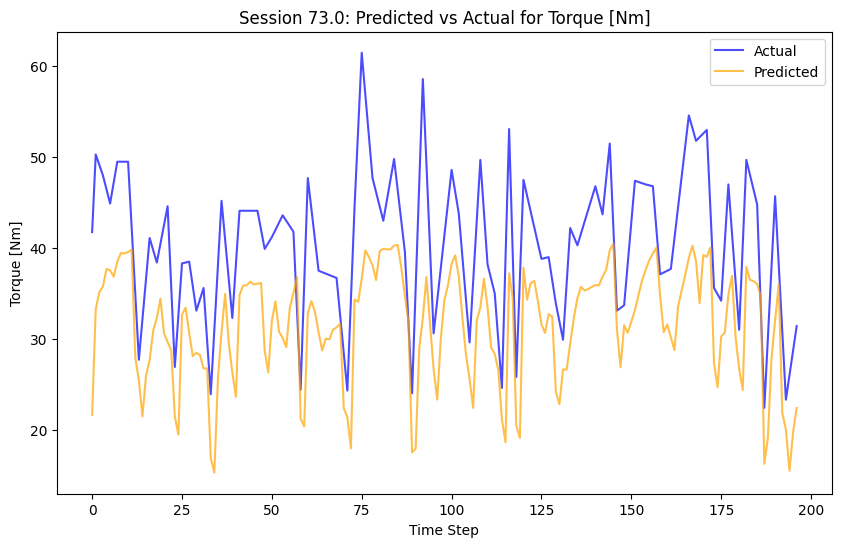

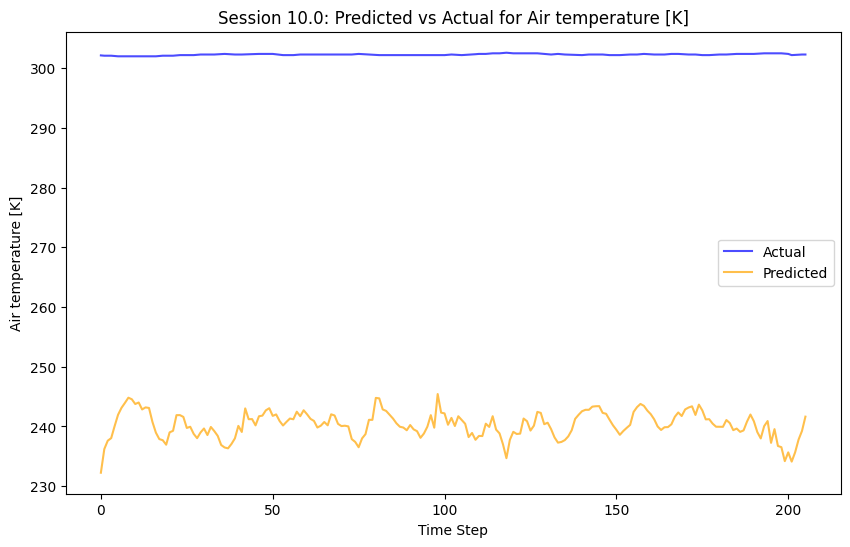

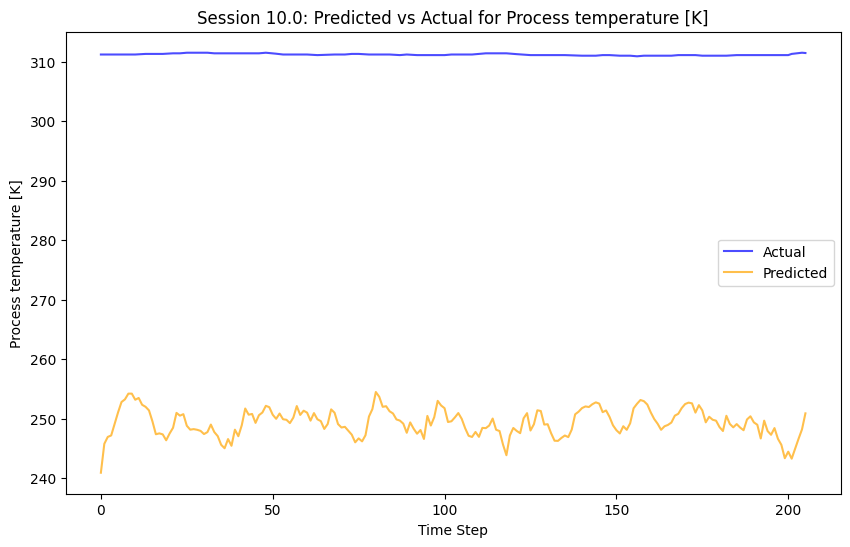

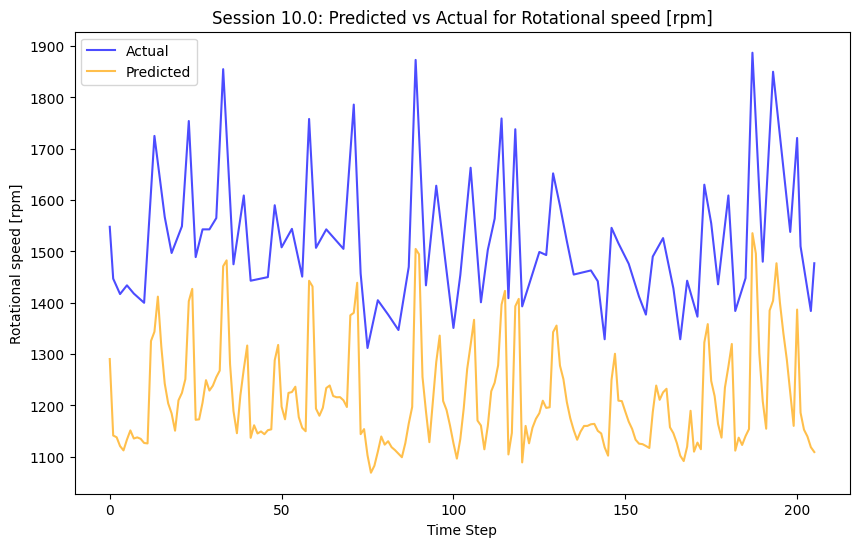

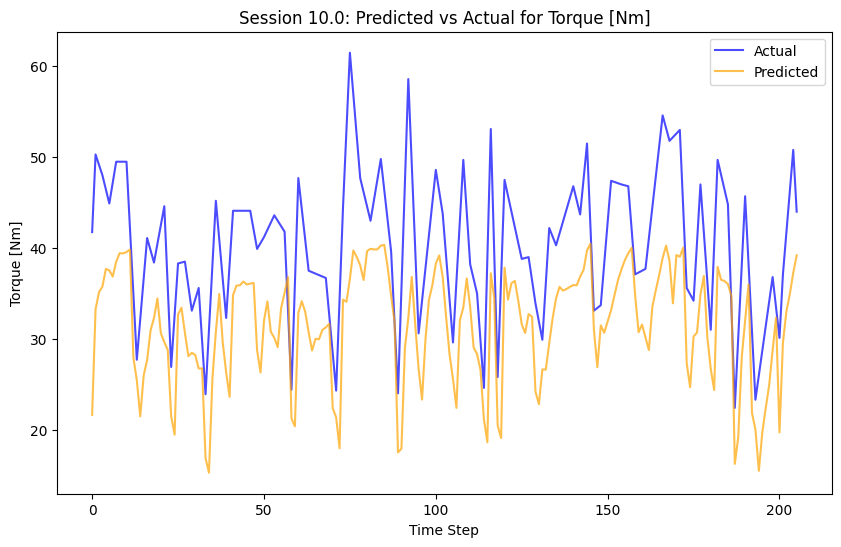

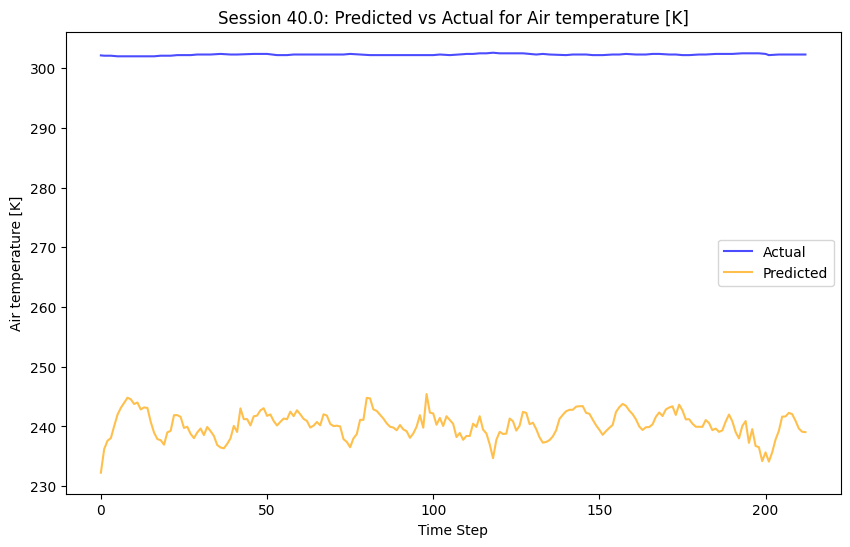

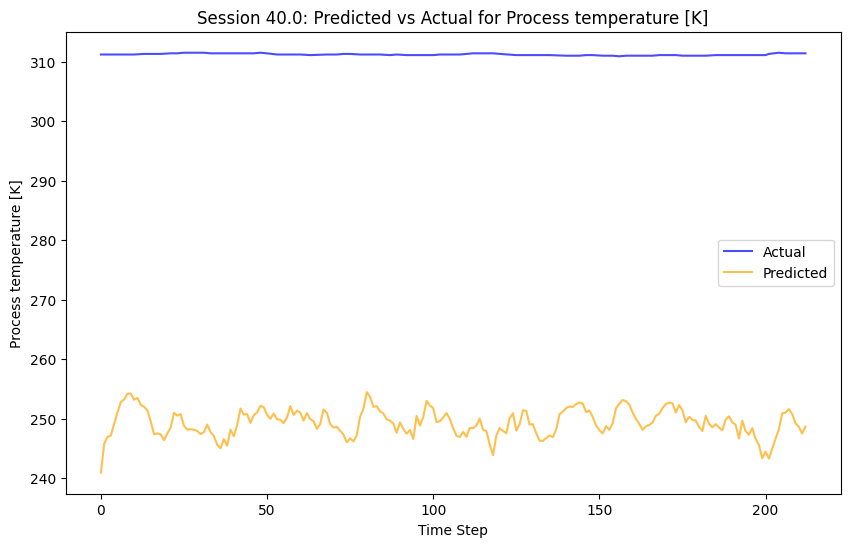

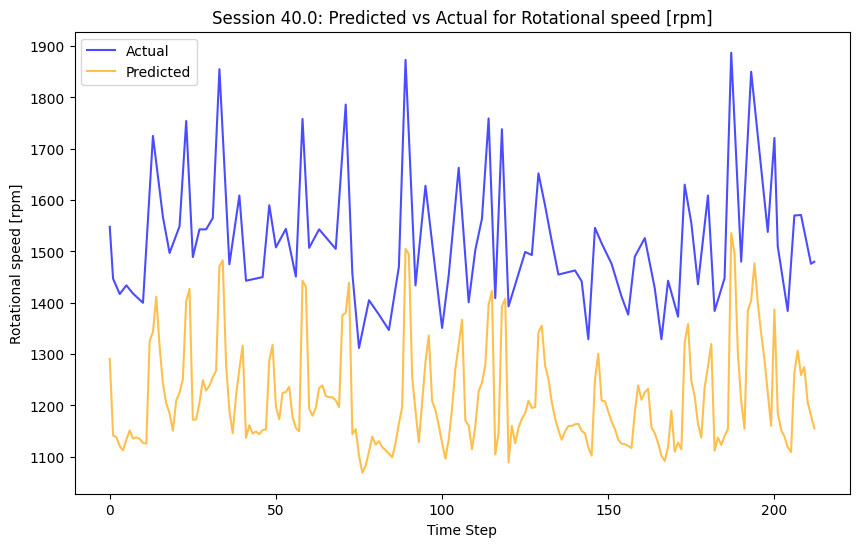

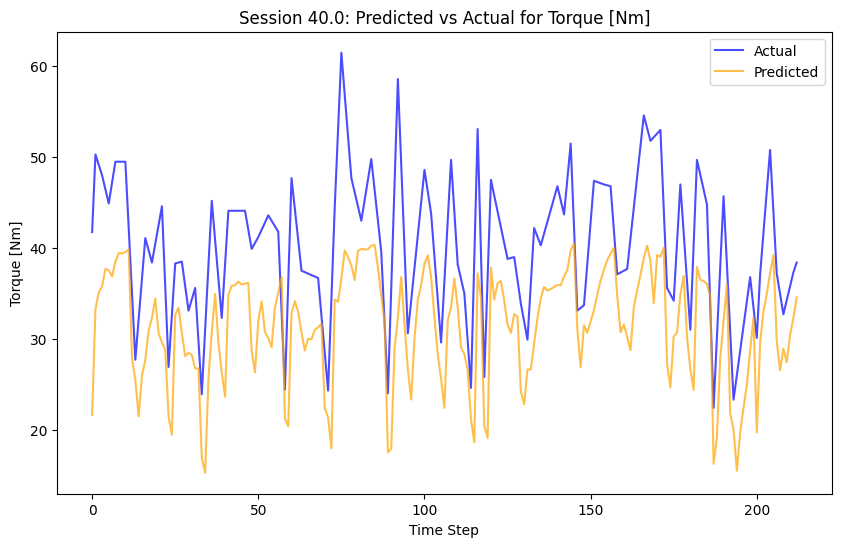

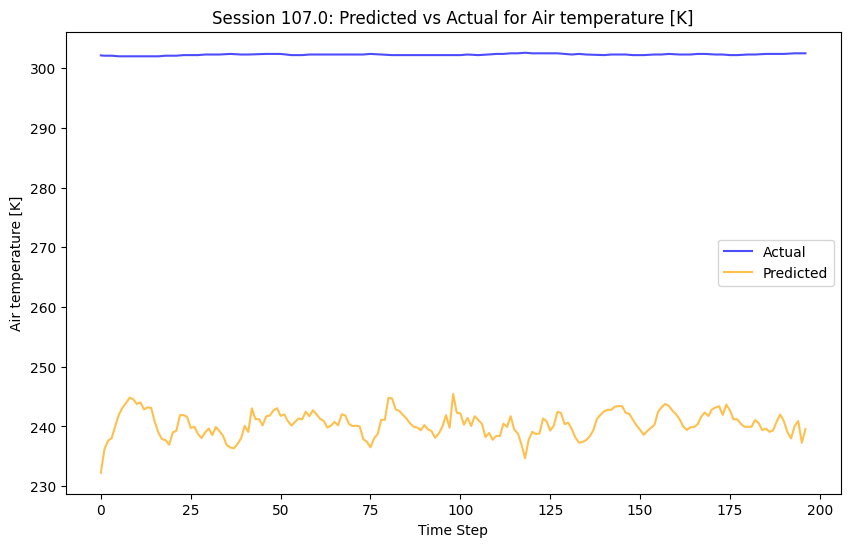

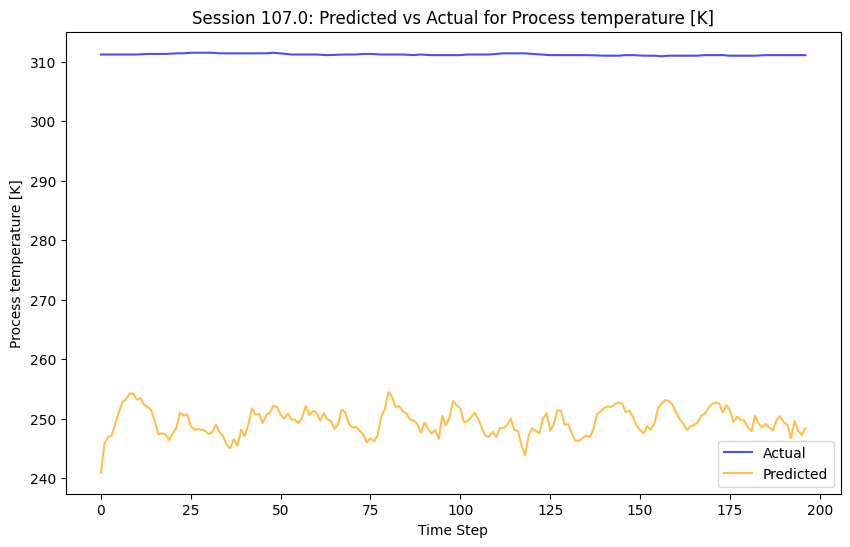

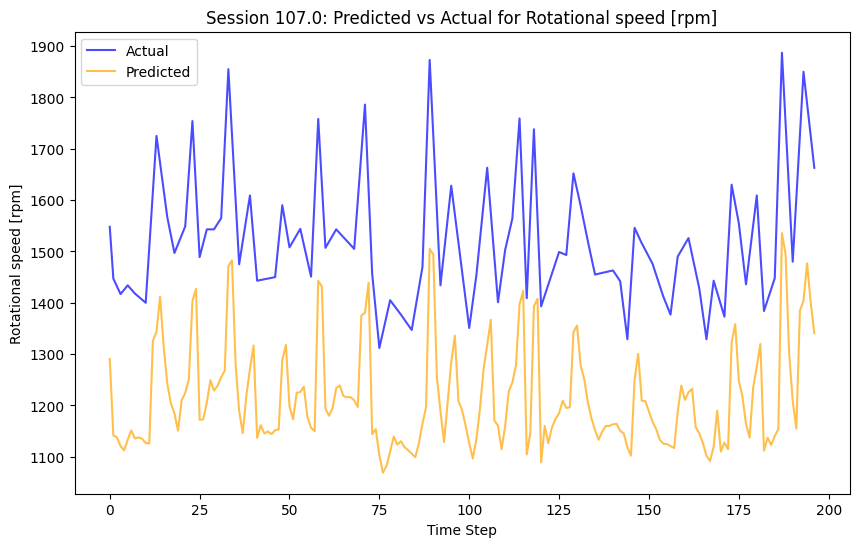

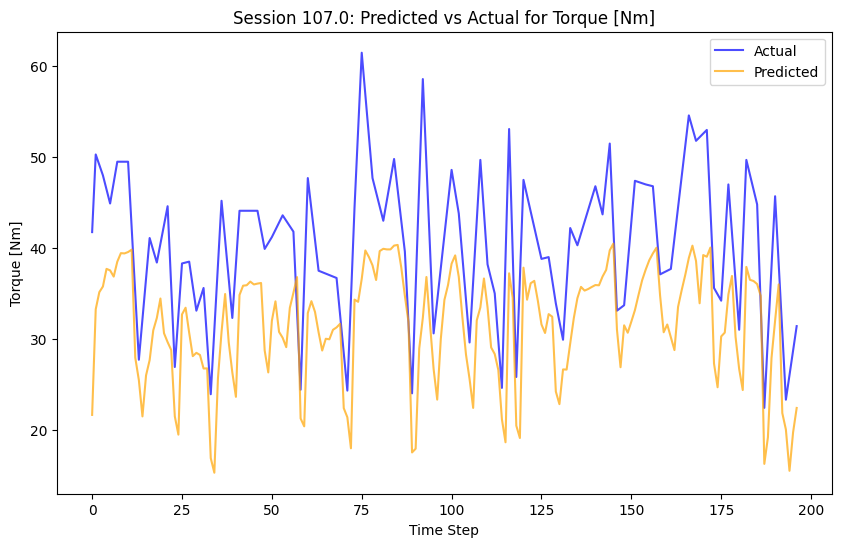

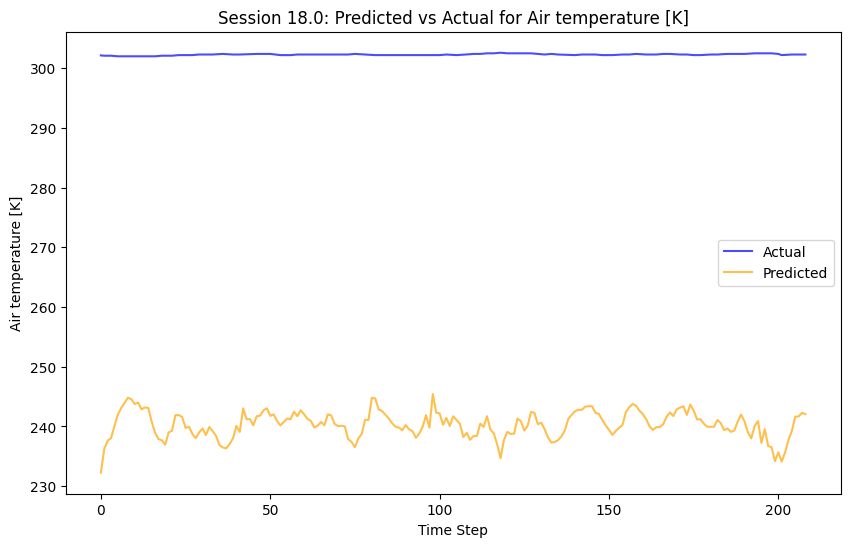

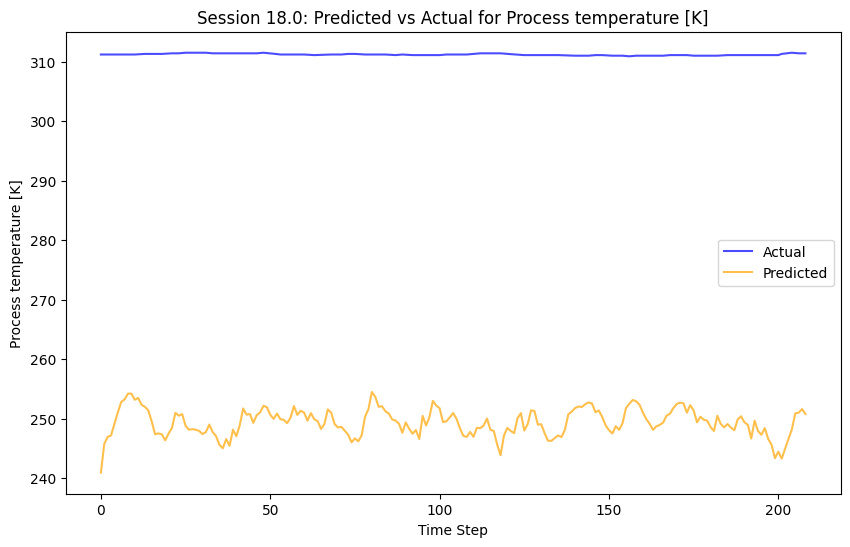

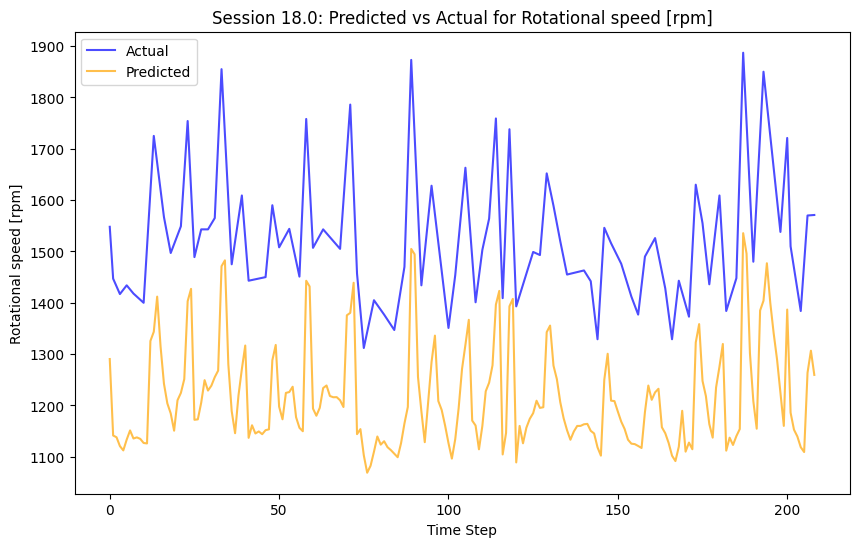

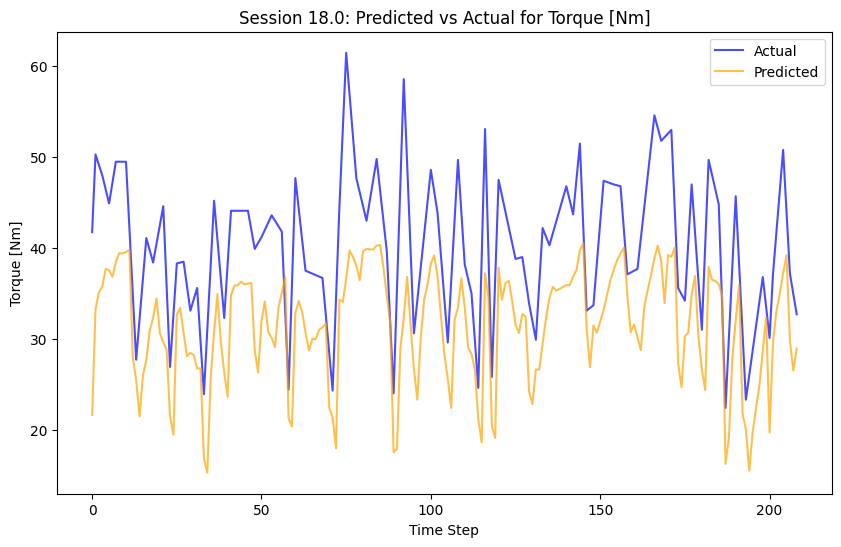

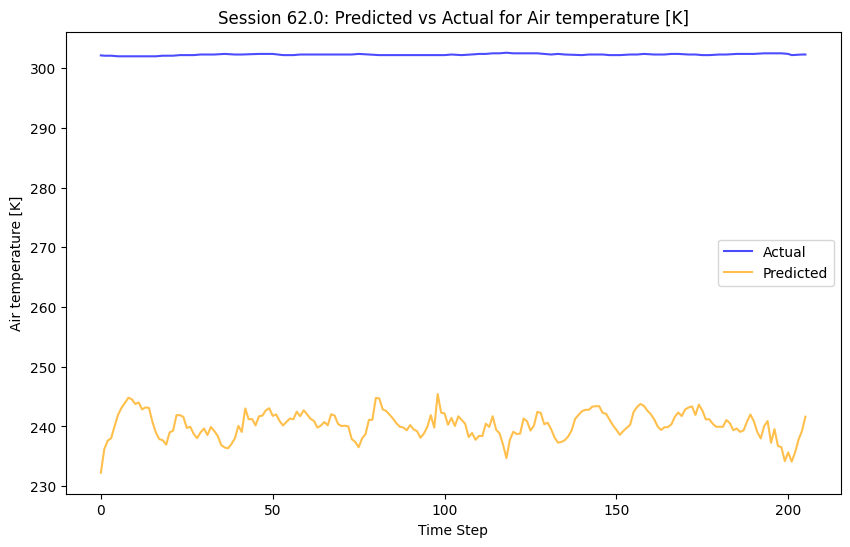

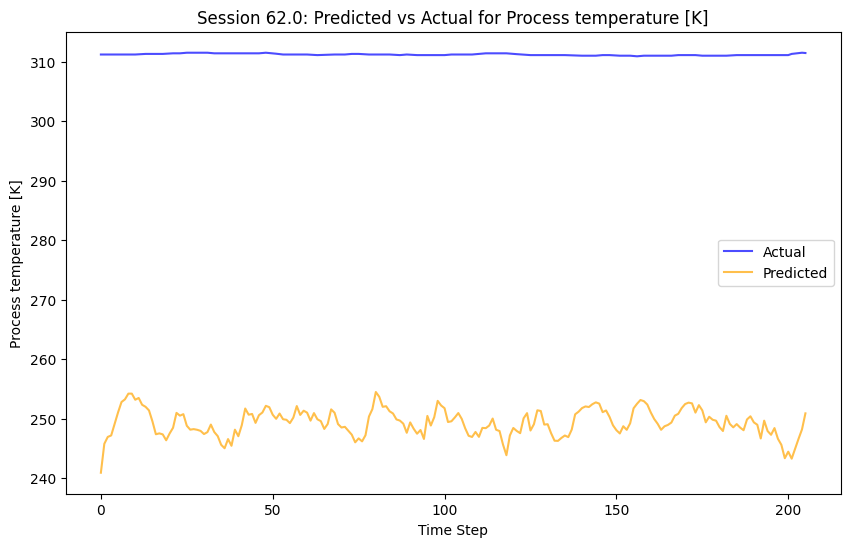

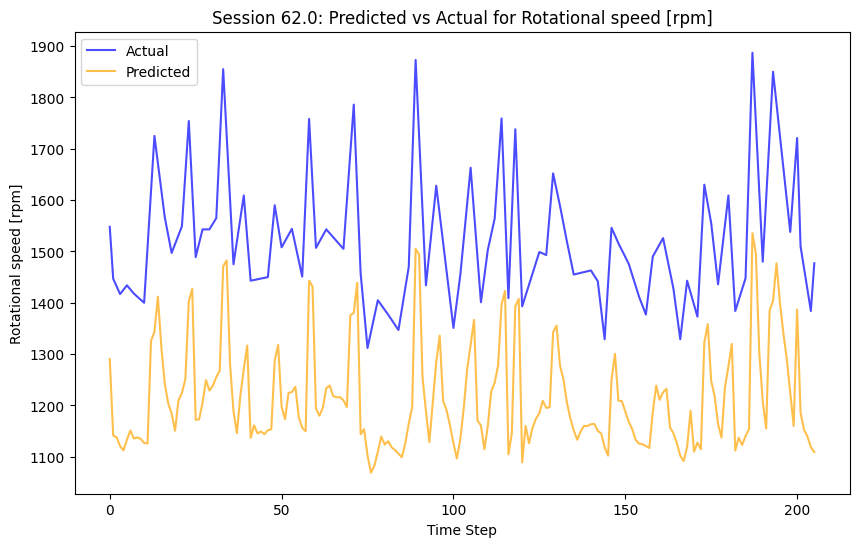

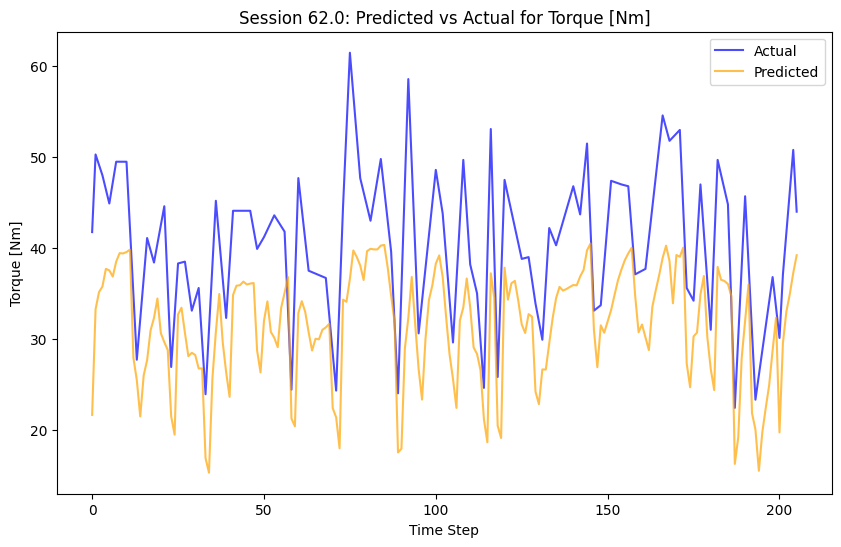

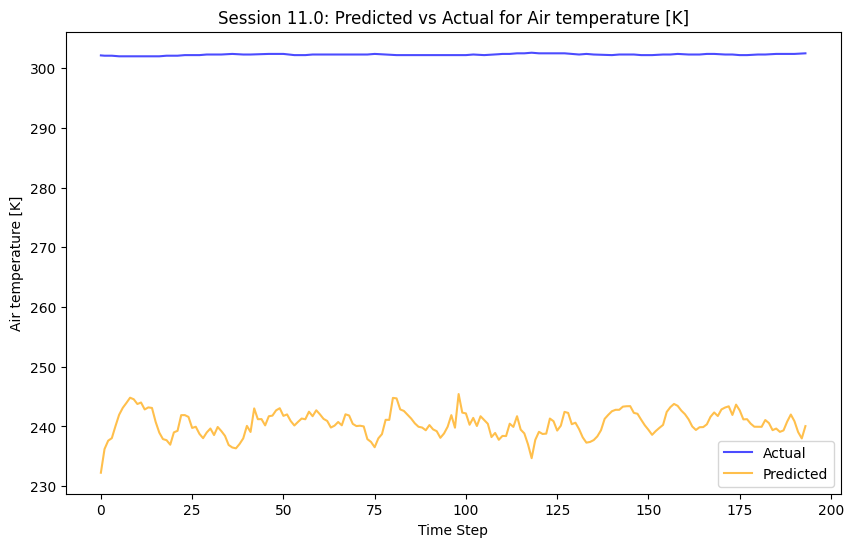

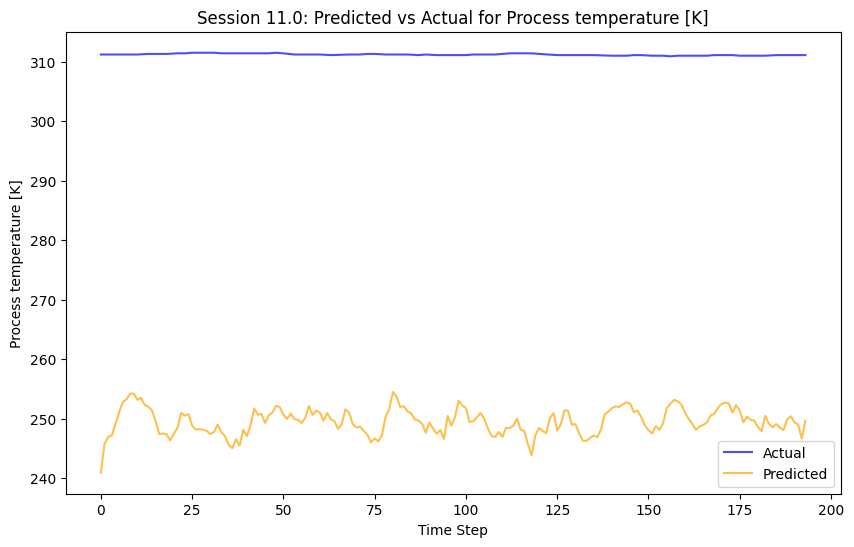

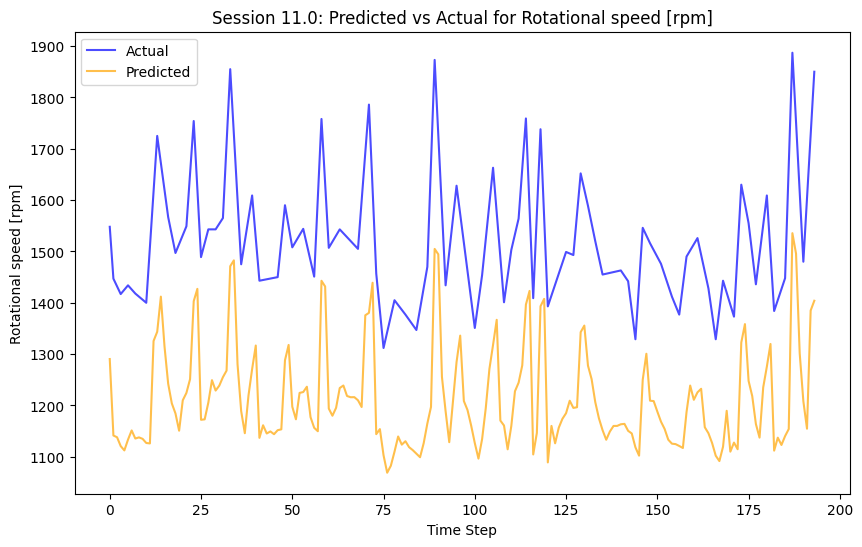

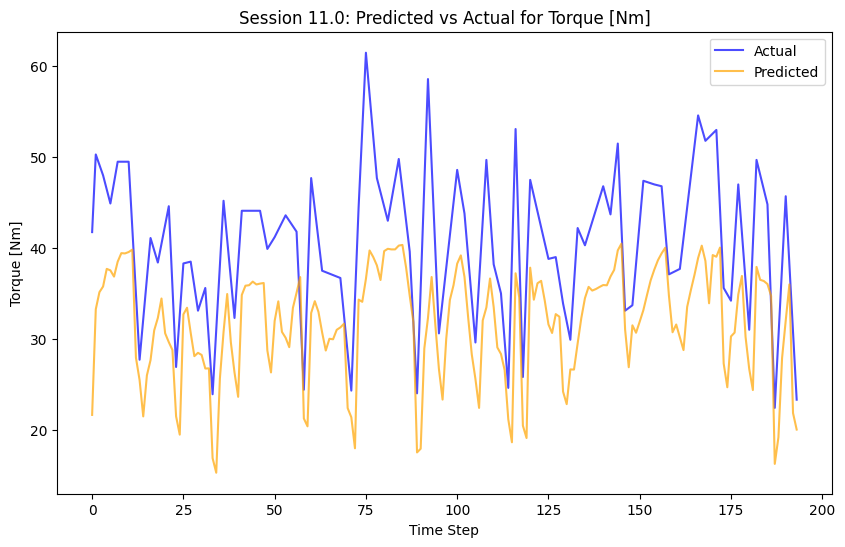

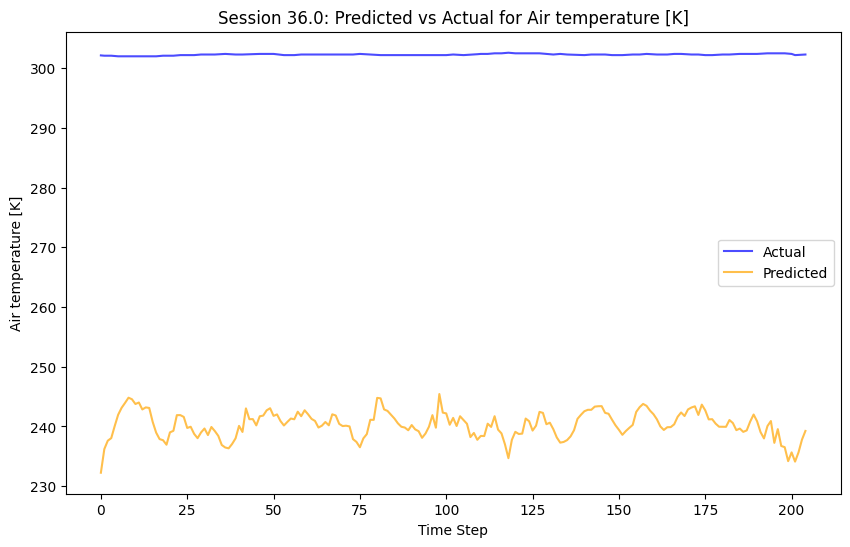

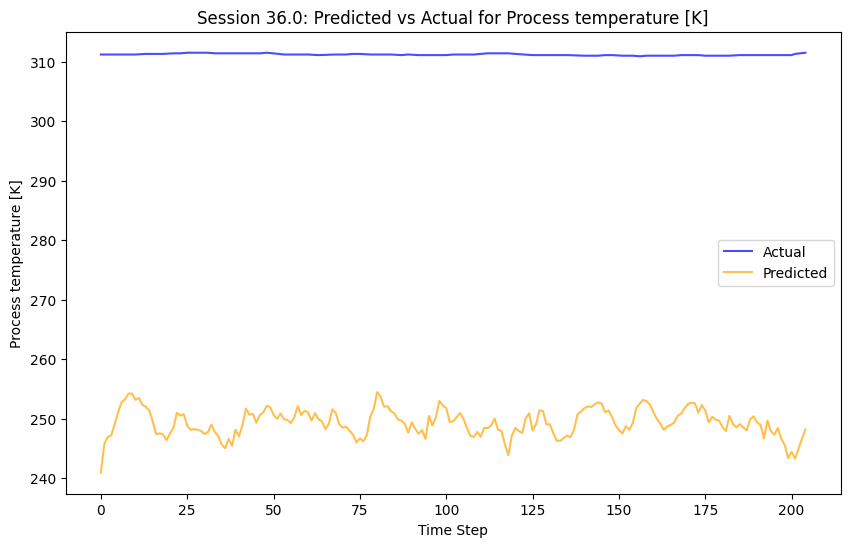

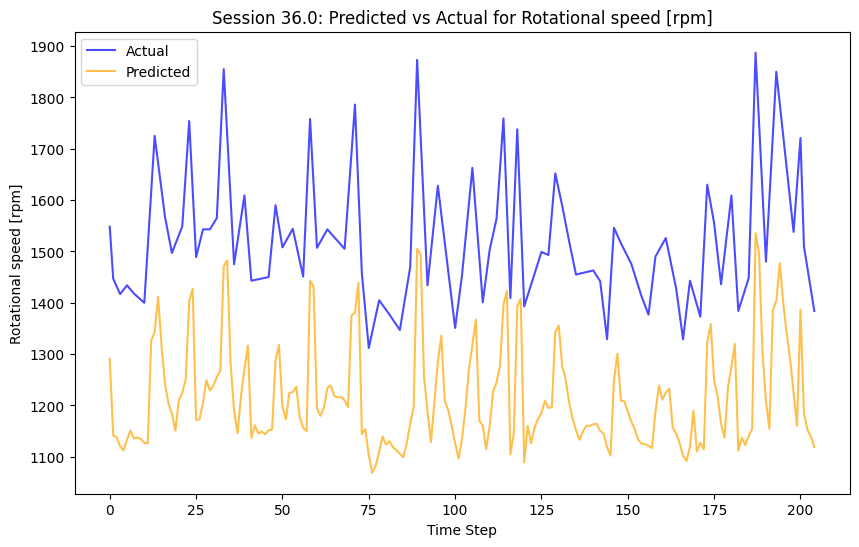

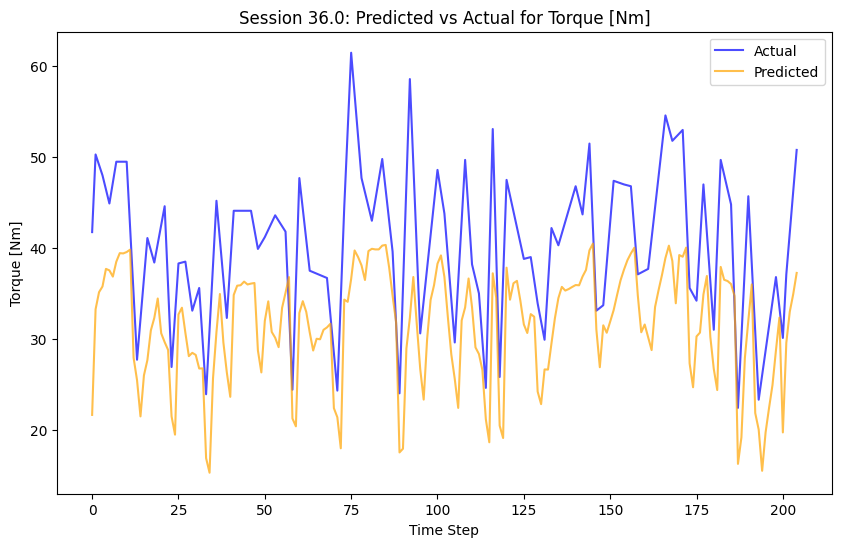

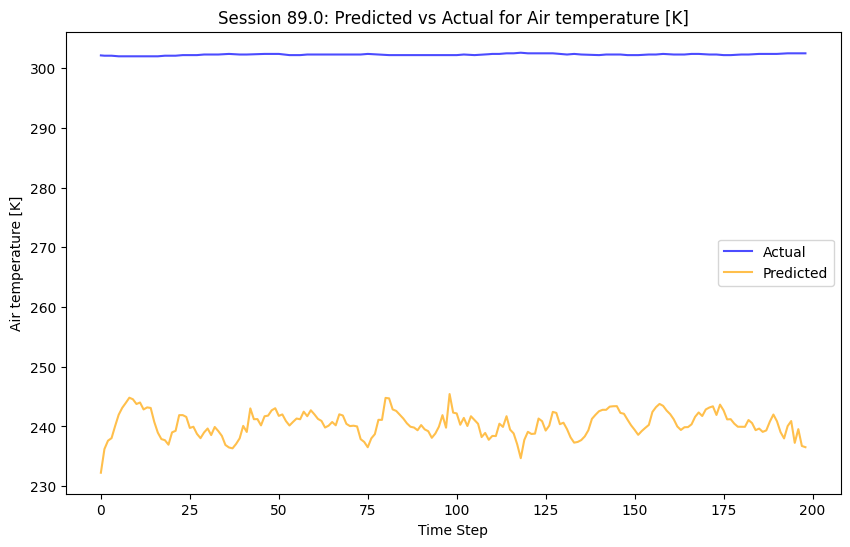

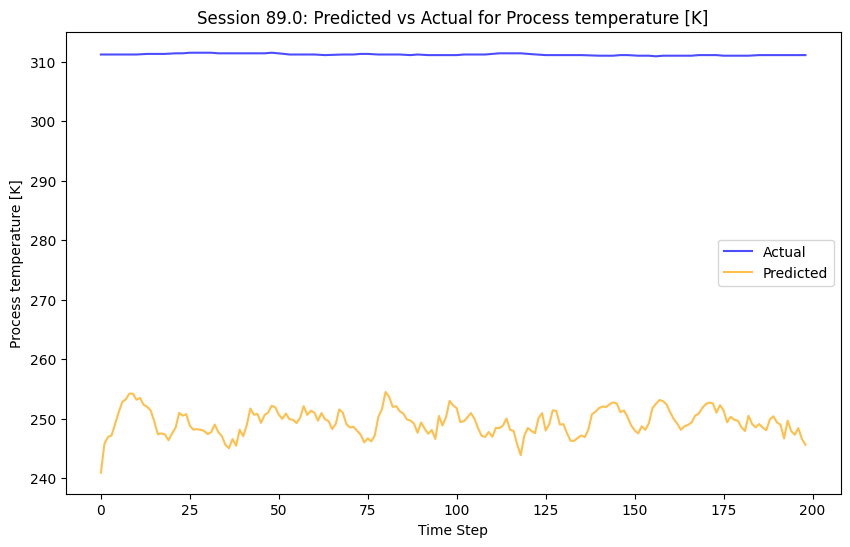

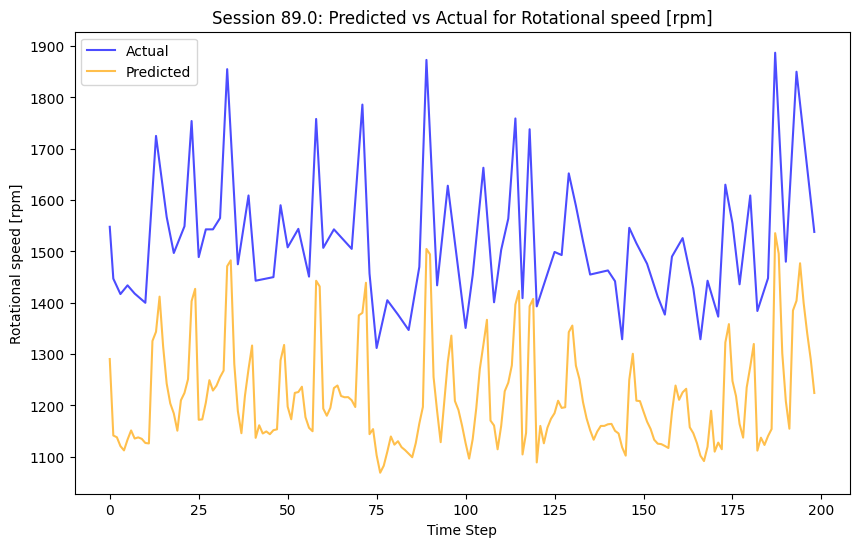

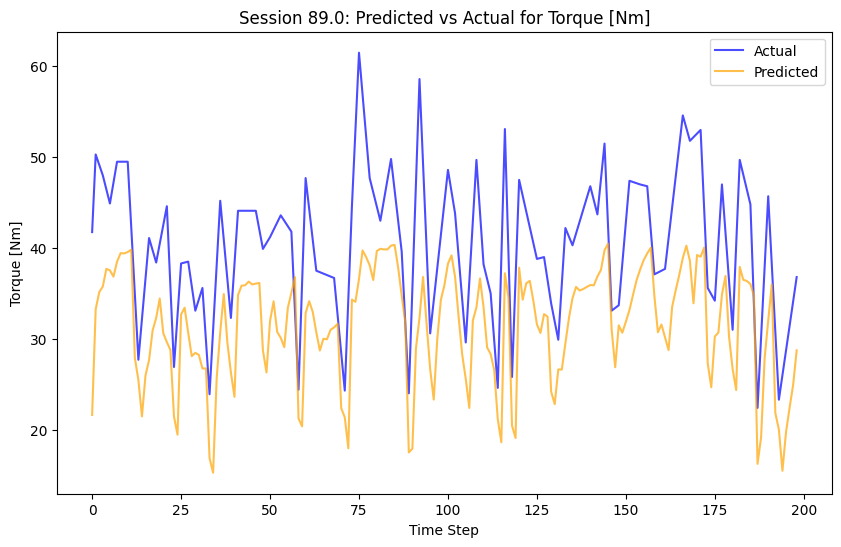

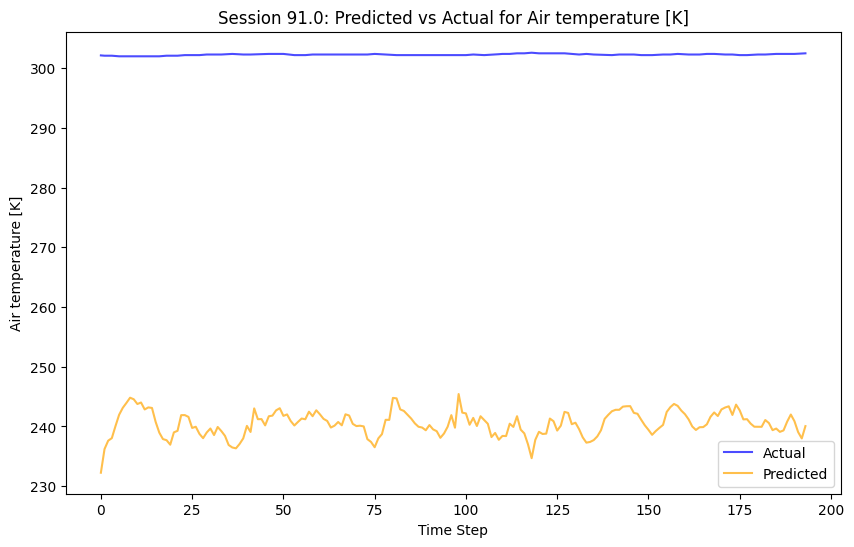

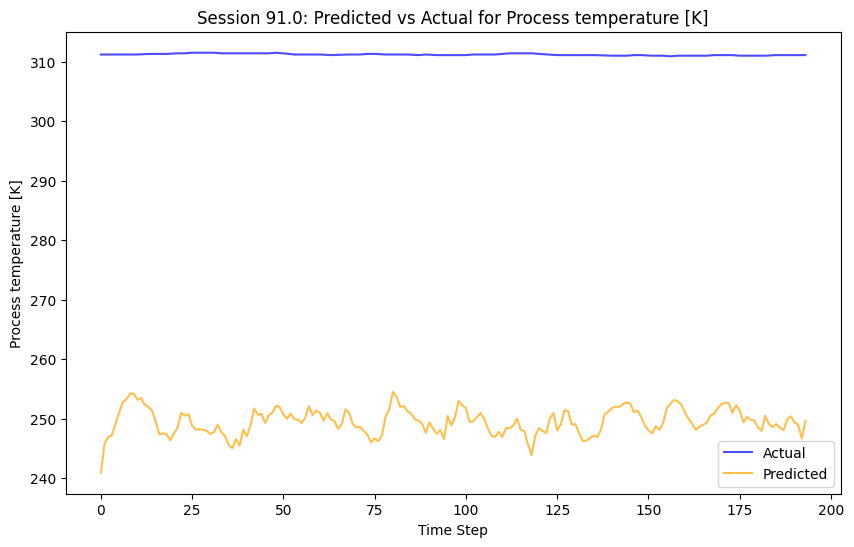

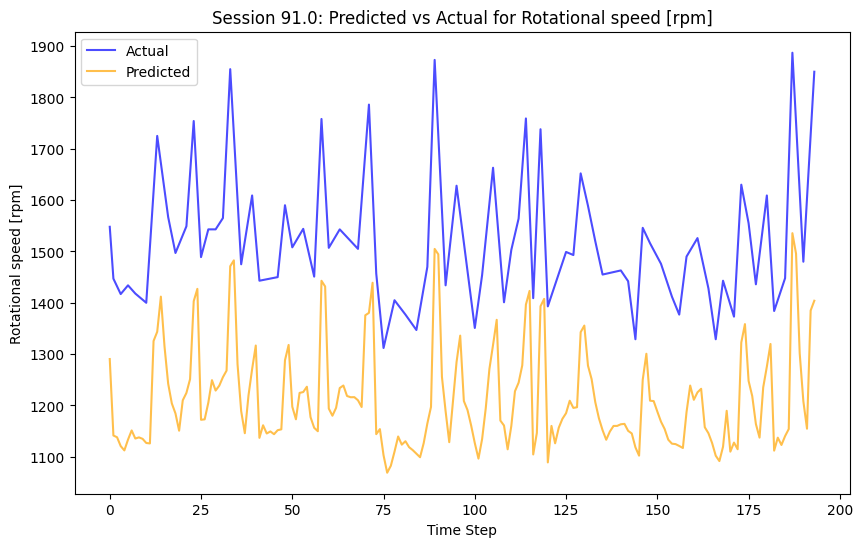

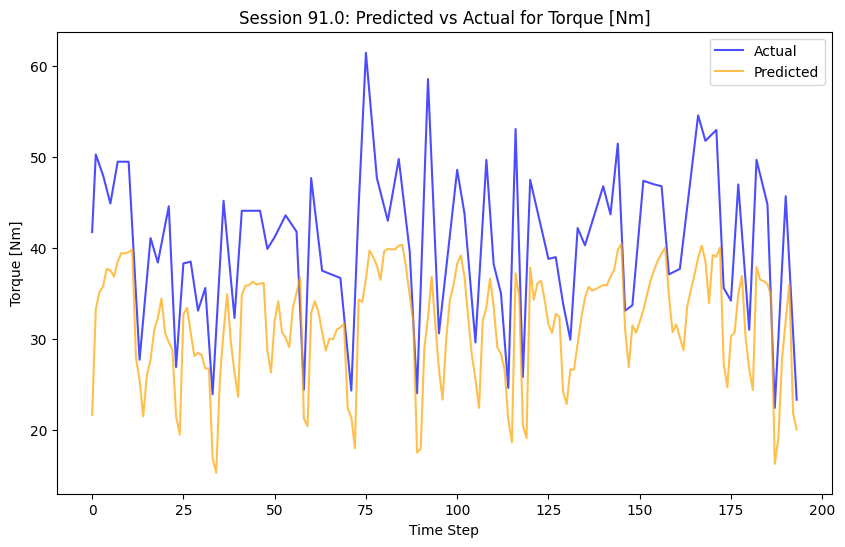

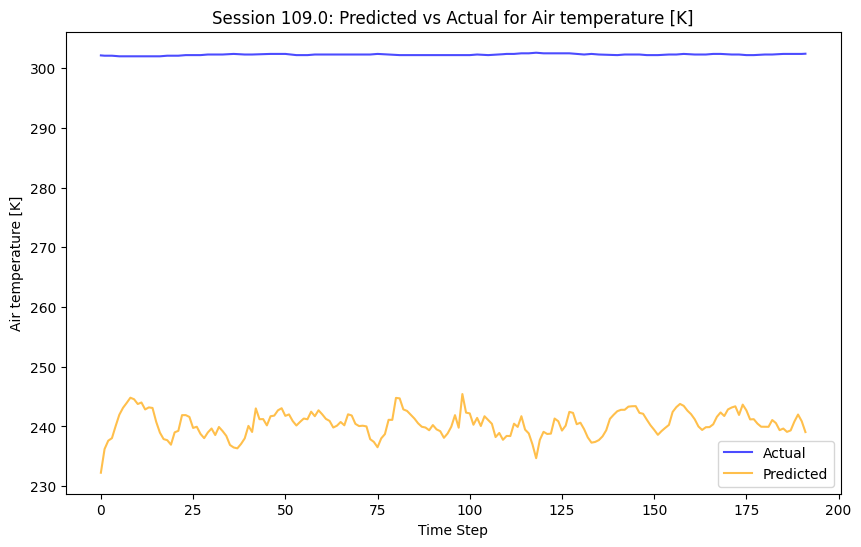

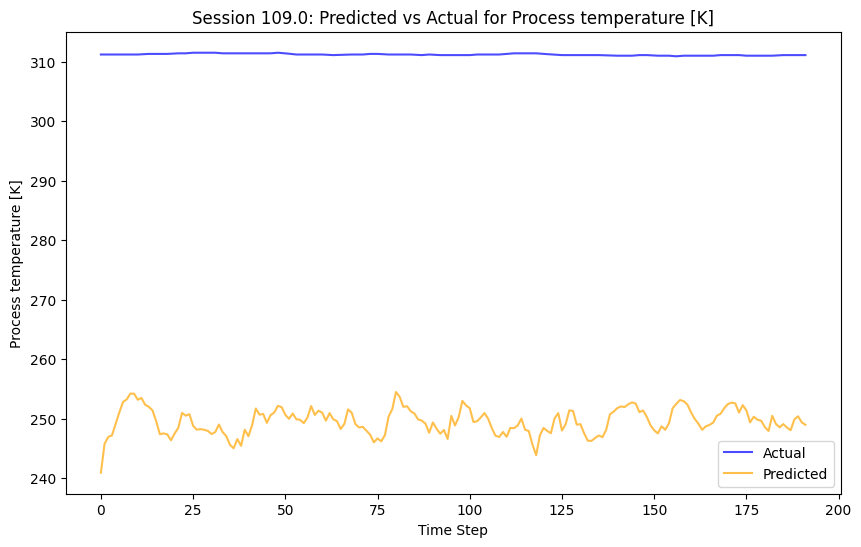

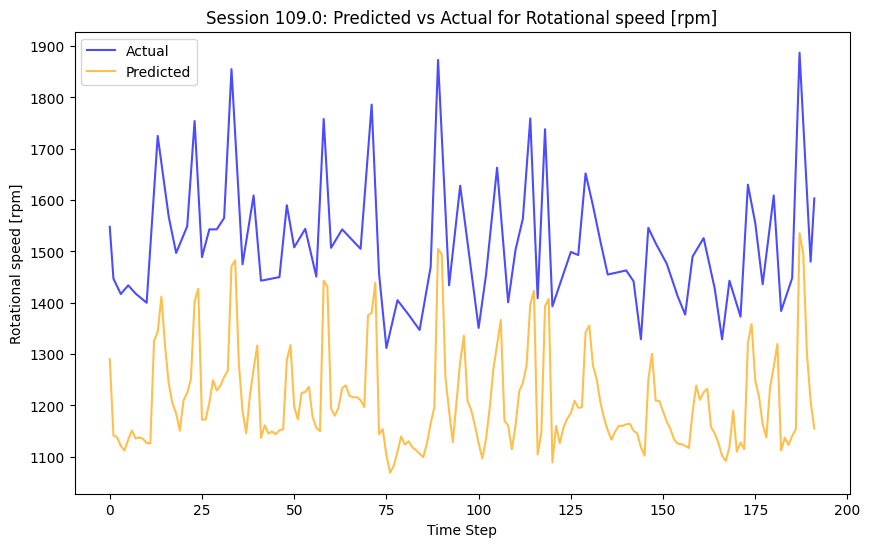

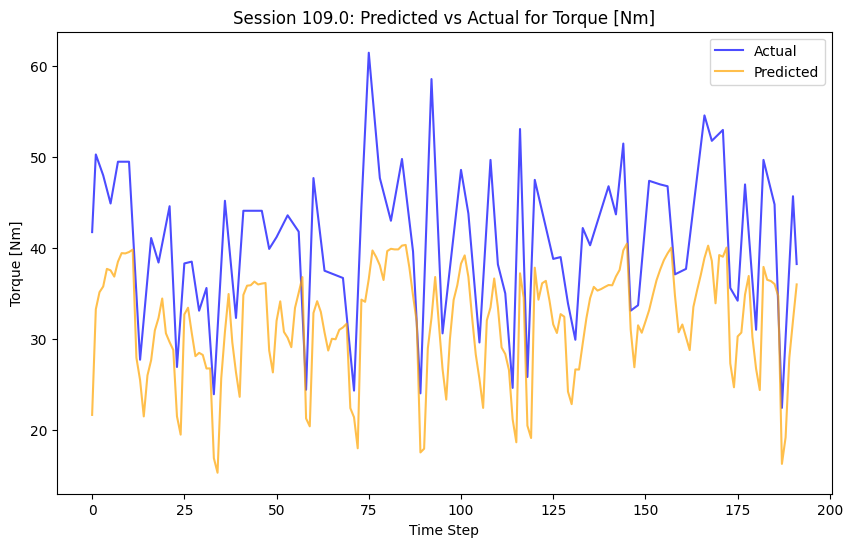

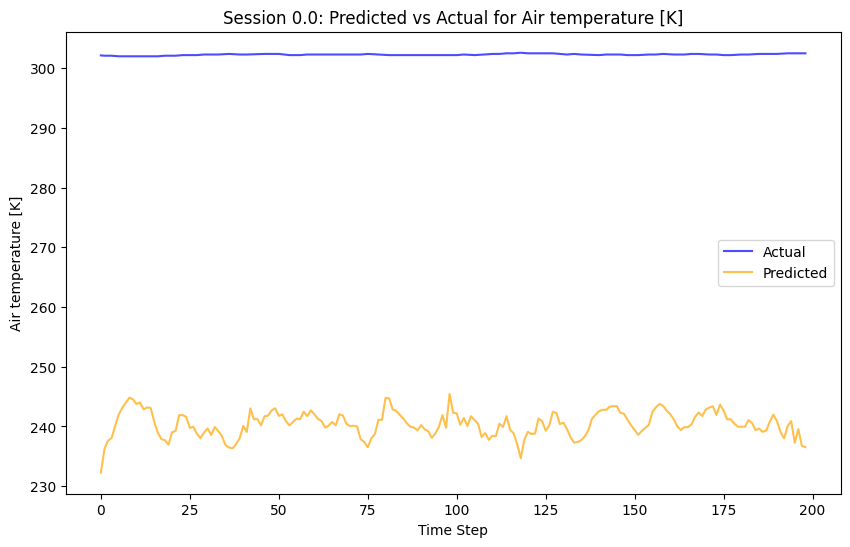

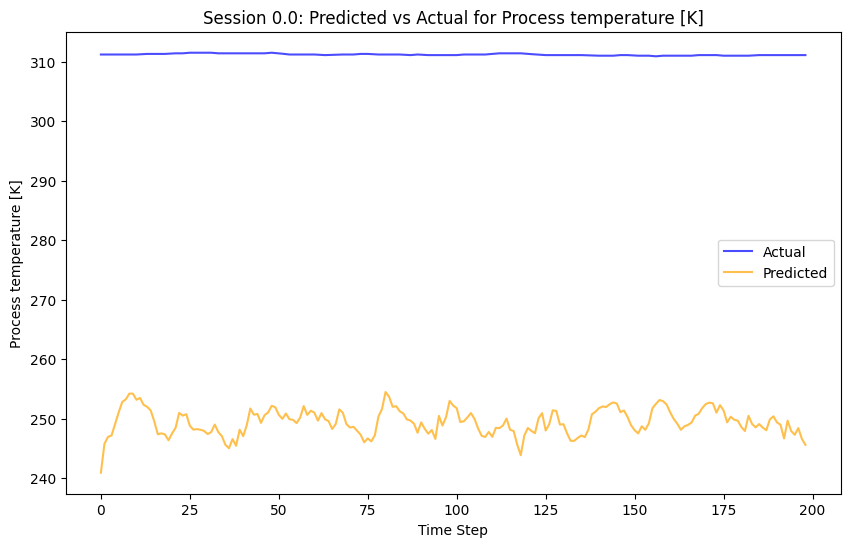

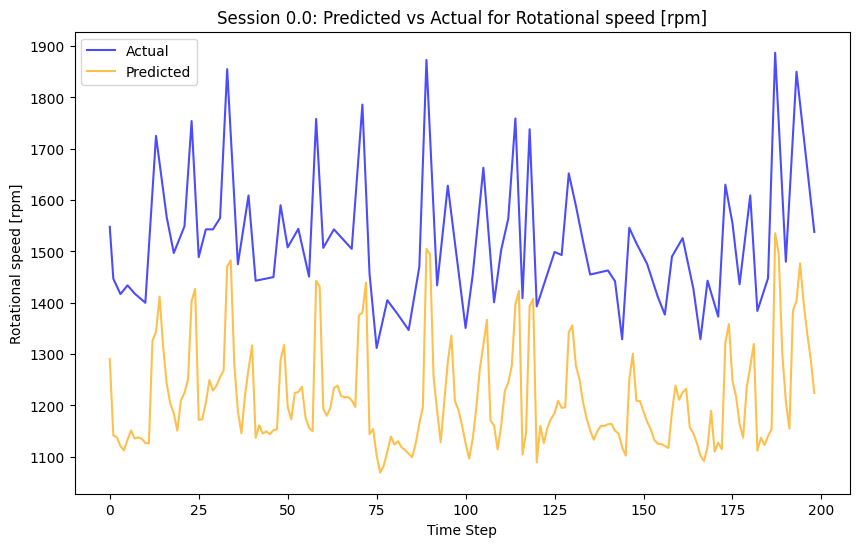

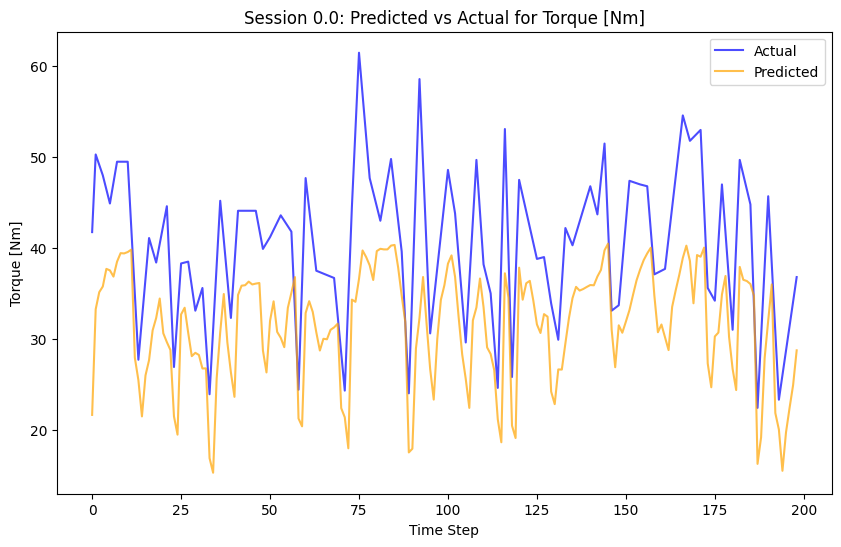

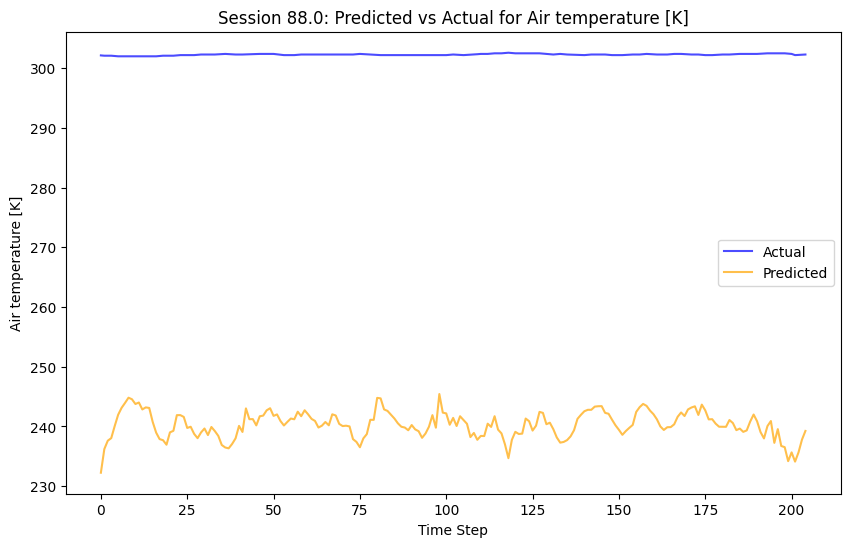

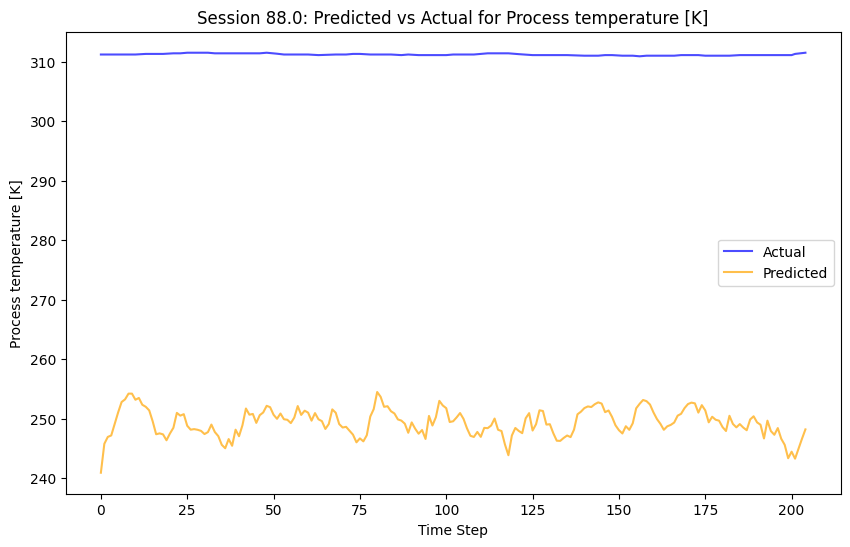

KeyboardInterrupt: 

In [ ]:
# Plot predicted vs actual for each session, STOP WHEN YOU FEEL COMFORTABLE, THIS WILL PRINT FOR A LONG TIME!
for session_id in predictions_df['Session_ID'].unique():
    session_data = predictions_df[predictions_df['Session_ID'] == session_id]
    
    for i, column in enumerate(indicator_columns):
        plt.figure(figsize=(10, 6))
        plt.plot(
            [a[i] for a in session_data['Actual']], label='Actual', color='blue', alpha=0.7
        )
        plt.plot(
            [p[i] for p in session_data['Predicted']], label='Predicted', color='orange', alpha=0.7
        )
        plt.title(f"Session {session_id}: Predicted vs Actual for {column}")
        plt.xlabel("Time Step")
        plt.ylabel(column)
        plt.legend()
        plt.show()
